In [164]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [5]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
pd.__version__

'1.4.4'

Pull surveillance data

In [86]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-04-27,02,Alaska,3,0.421688
1,2,2024-04-27,01,Alabama,16,0.315970
2,3,2024-04-27,05,Arkansas,30,0.986233
3,4,2024-04-27,04,Arizona,106,1.443941
4,5,2024-04-27,06,California,151,0.388309
...,...,...,...,...,...,...
6143,6144,2022-02-12,50,Vermont,0,0.000000
6144,6145,2022-02-12,53,Washington,8,0.103415
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6146,6147,2022-02-12,54,West Virginia,5,0.281694


In [8]:
observations.to_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq", index=False)

Pull Flu Scenario Modeling Hub data

In [13]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4

for model in models:
    predictions = pull_flu_scenario_modeling_hub_predictions(model,dates)
    predictions['Model'] = model
    
    predictions = predictions[predictions['target'] =='inc hosp']


    numweeks = list(predictions.horizon.unique())

    start_date = list(predictions.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    df = predictions.merge(dfdates, how='inner', on='horizon')


    df.to_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd{rd}.pq', index=False)
    
    
    

Data for model UT-ImmunoSEIRS and date ['2023-09-03'] unavailable


TypeError: 'NoneType' object does not support item assignment

In [7]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


In [8]:
predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    print(model, len(df.location.unique()))
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


remove models with only one location

In [10]:
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

predictionsall = predictionsall[~predictionsall['Model'].isin(singleloc_models)]

In [11]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

NameError: name 'observations' is not defined

In [13]:
predictions_traj

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
0,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,1.0,0-130,3.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
1,2023-09-03,A-2023-08-14,inc hosp,2.0,01,sample,1.0,0-130,26.000000,MOBS_NEU-GLEAM_FLU,2023-09-16
2,2023-09-03,A-2023-08-14,inc hosp,3.0,01,sample,1.0,0-130,12.000000,MOBS_NEU-GLEAM_FLU,2023-09-23
3,2023-09-03,A-2023-08-14,inc hosp,4.0,01,sample,1.0,0-130,19.000000,MOBS_NEU-GLEAM_FLU,2023-09-30
4,2023-09-03,A-2023-08-14,inc hosp,5.0,01,sample,1.0,0-130,13.000000,MOBS_NEU-GLEAM_FLU,2023-10-07
...,...,...,...,...,...,...,...,...,...,...,...
1040395,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,96,0-130,11386.833555,UT-ImmunoSEIRS,2024-04-27
1040396,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,97,0-130,10189.685771,UT-ImmunoSEIRS,2024-04-27
1040397,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,98,0-130,6137.291993,UT-ImmunoSEIRS,2024-04-27
1040398,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,99,0-130,5867.128822,UT-ImmunoSEIRS,2024-04-27


make figure showing trajectory vs quantile format

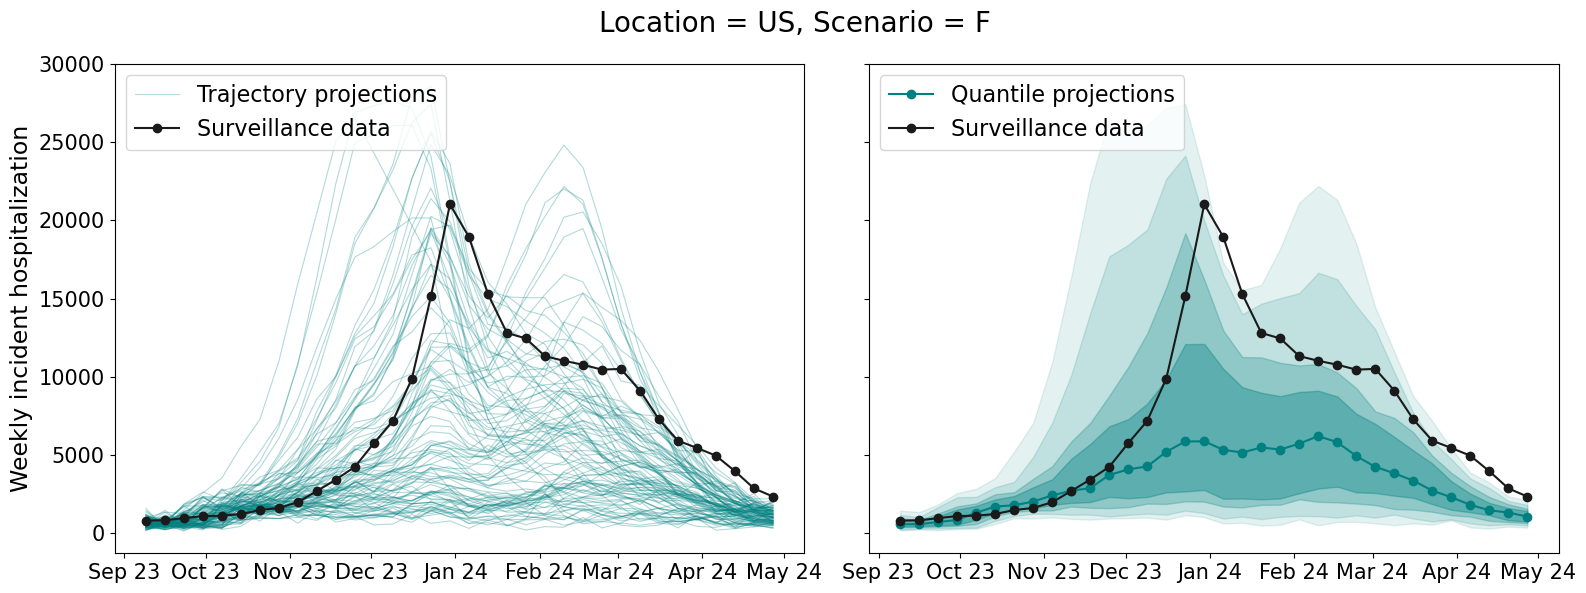

In [15]:
# include all models, even those only submitting for one location
model = 'MOBS_NEU-GLEAM_FLU'

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
    
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == model)]   

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)


scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= max_date) & \
                              (predictions.target_end_date >= start_week)]

plt.subplot(1,2,1)

for traj in predictionsfilt.output_type_id.unique():
    p = predictionsfilt[predictionsfilt.output_type_id == traj]
    plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8)
    
plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8, label=fr"Trajectory projections")


observations = format_observations(location=location)

axes[0].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes[0])

plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=17)
plt.legend(loc='upper left', fontsize=16)
axes[0].tick_params(axis='both', labelsize=15)


plt.subplot(1,2,2)

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='teal', alpha=1,
                               label=fr"Quantile projections")
    
observations = format_observations(location=location)

axes[1].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes[1])

axes[1].tick_params(axis='both', labelsize=15)

#set y axis 
#axes[1].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization")
    
plt.legend(loc='upper left', fontsize=16)

plt.suptitle(f'Location = {location}, Scenario = {scenario}', fontsize=20)

plt.tight_layout()

plt.savefig('../trajectory_quantile_format.pdf')
plt.show()

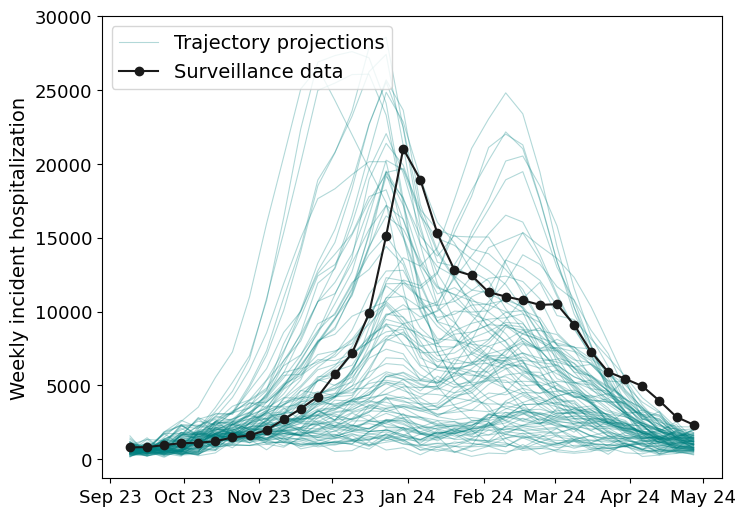

In [90]:
# include all models, even those only submitting for one location
model = 'MOBS_NEU-GLEAM_FLU'

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
    
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == model)]   

fig, ax = plt.subplots(1,1, figsize=(8,6), sharey=True)


scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= max_date) & \
                              (predictions.target_end_date >= start_week)]

#plt.subplot(1,2,1)

for traj in predictionsfilt.output_type_id.unique():
    p = predictionsfilt[predictionsfilt.output_type_id == traj]
    plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8)
    
plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8, label=fr"Trajectory projections")


observations = format_observations(location=location)

ax.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(ax)

plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=14)
plt.legend(loc='upper left', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

#plt.tight_layout()

plt.savefig('../trajectory_format.pdf')
plt.show()

In [91]:
predictionsfilt

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
1466400,2023-09-03,F-2023-08-14,inc hosp,1.0,US,sample,1.0,0-130,870.000,MOBS_NEU-GLEAM_FLU,2023-09-09
1466401,2023-09-03,F-2023-08-14,inc hosp,2.0,US,sample,1.0,0-130,574.000,MOBS_NEU-GLEAM_FLU,2023-09-16
1466402,2023-09-03,F-2023-08-14,inc hosp,3.0,US,sample,1.0,0-130,1257.751,MOBS_NEU-GLEAM_FLU,2023-09-23
1466403,2023-09-03,F-2023-08-14,inc hosp,4.0,US,sample,1.0,0-130,2091.459,MOBS_NEU-GLEAM_FLU,2023-09-30
1466404,2023-09-03,F-2023-08-14,inc hosp,5.0,US,sample,1.0,0-130,1478.321,MOBS_NEU-GLEAM_FLU,2023-10-07
...,...,...,...,...,...,...,...,...,...,...,...
1470290,2023-09-03,F-2023-08-14,inc hosp,30.0,US,sample,100.0,0-130,3106.656,MOBS_NEU-GLEAM_FLU,2024-03-30
1470291,2023-09-03,F-2023-08-14,inc hosp,31.0,US,sample,100.0,0-130,2435.152,MOBS_NEU-GLEAM_FLU,2024-04-06
1470292,2023-09-03,F-2023-08-14,inc hosp,32.0,US,sample,100.0,0-130,2058.734,MOBS_NEU-GLEAM_FLU,2024-04-13
1470293,2023-09-03,F-2023-08-14,inc hosp,33.0,US,sample,100.0,0-130,1485.811,MOBS_NEU-GLEAM_FLU,2024-04-20


Calculate energy score for individual models at each scenario, location, and week

In [17]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

energyscoresdf = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in predictions_traj.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [18]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,426.430823,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,410.700957,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,410.799822,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,408.848089,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,421.623785,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,25598.171912,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,27081.777290,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,25498.213156,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,24345.522962,hosp,US,US,328728466


In [19]:
energyscoresdf.to_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

calculate normalized energy score for individual models

In [20]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

energyscoresdf_norm = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in predictions_traj.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = normalized_energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf_norm = pd.concat([energyscoresdf_norm, newrow])

energyscoresdf_norm = energyscoresdf_norm.reset_index()
energyscoresdf_norm = energyscoresdf_norm.drop(columns=['index'])   


energyscoresdf_norm = pd.merge(energyscoresdf_norm, locations, how = 'inner', on = 'location')


no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [21]:
energyscoresdf_norm

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,2.796140,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,2.545872,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,3.157534,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,2.542182,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,3.317210,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,3.312413,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,3.608566,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,3.278241,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,3.155635,hosp,US,US,328728466


In [22]:
energyscoresdf_norm.to_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_norm_individual_rd4_hosp_521.pkl")



Calculate WIS for all individual models

In [23]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")


# filter by quantiles and only look at age group with all ages combined
predictions_quant = predictionsall[(predictionsall.output_type == 'quantile') & \
                                   (predictionsall.age_group == '0-130')]


# filter by dates with data
predictions_quant = predictions_quant[predictions_quant.target_end_date <= pd.to_datetime(observations.date.max())]


            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

wisdf = pd.DataFrame()


predictions_quant['target_end_date'] = pd.to_datetime(predictions_quant['target_end_date'])

for model in predictions_quant.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_quant[(predictions_quant.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_quant.location == loc) & \
                                        (predictions_quant.Model == model) & \
                                        (predictions_quant.target_end_date <= max_date) & \
                                        (predictions_quant.target_end_date >= start_week)]
            
            predictionsfilt = predictionsfilt.rename(columns={'output_type_id':'quantile', 'output_type':'type'})
            
            
            #predictionsfilt = predictionsfilt.drop(columns=['horizon', 'age_group', 'origin_date', 'target'])
            
            predictionsfilt['quantile'] = predictionsfilt['quantile'].astype("float")

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #filter location
            observations = observations[observations['location'] == loc]

            observations = observations[['location', 'date', 'value']]
            
            #transform to Observation object
            observations = Observations(observations)

            

            ## calculate WIS 
            
            scenarios = list(predictionsfilt['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(predictionsfilt[predictionsfilt['scenario_id'] == scenario],
                                            t_col='target_end_date') for scenario in scenarios]

            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)]

            aggregated_scores = dict()

            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)

                aggregated_scores[label] = d

            
            for label in labels:
                wis = aggregated_scores[label]['wis_mean']
                

            ##
            
            

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':wis, 
                                'target':target}, index=[0])

            wisdf = pd.concat([wisdf, newrow])

wisdf = wisdf.reset_index()
wisdf = wisdf.drop(columns=['index'])   


wisdf = pd.merge(wisdf, locations, how = 'inner', on = 'location')



no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [24]:
wisdf

,Model,Label,location,WIS,target,abbreviation,location_name,population
0,Ensemble,Scenario A,1,32.096365,hosp,AL,Alabama,4903185
1,Ensemble,Scenario B,1,23.844404,hosp,AL,Alabama,4903185
2,Ensemble,Scenario C,1,32.012242,hosp,AL,Alabama,4903185
3,Ensemble,Scenario D,1,21.510710,hosp,AL,Alabama,4903185
4,Ensemble,Scenario E,1,31.561645,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1633,USC-SIkJalpha,Scenario B,US,3186.455519,hosp,US,US,328728466
1634,USC-SIkJalpha,Scenario C,US,3184.368746,hosp,US,US,328728466
1635,USC-SIkJalpha,Scenario D,US,3186.795785,hosp,US,US,328728466
1636,USC-SIkJalpha,Scenario E,US,3191.250160,hosp,US,US,328728466


In [25]:
wisdf.to_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl')

calculate WIS normalized by standard deviation at each week, averaged over prediction window

In [26]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")


# filter by quantiles and only look at age group with all ages combined
predictions_quant = predictionsall[(predictionsall.output_type == 'quantile') & \
                                   (predictionsall.age_group == '0-130')]


# filter by dates with data
predictions_quant = predictions_quant[predictions_quant.target_end_date <= pd.to_datetime(observations.date.max())]


            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

wisdf_timestamp = pd.DataFrame()


predictions_quant['target_end_date'] = pd.to_datetime(predictions_quant['target_end_date'])

for model in predictions_quant.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_quant[(predictions_quant.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_quant.location == loc) & \
                                        (predictions_quant.Model == model) & \
                                        (predictions_quant.target_end_date <= max_date) & \
                                        (predictions_quant.target_end_date >= start_week)]
            
            predictionsfilt = predictionsfilt.rename(columns={'output_type_id':'quantile', 'output_type':'type'})
            
            
            #predictionsfilt = predictionsfilt.drop(columns=['horizon', 'age_group', 'origin_date', 'target'])
            
            predictionsfilt['quantile'] = predictionsfilt['quantile'].astype("float")

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #filter location
            observations = observations[observations['location'] == loc]

            observations = observations[['location', 'date', 'value']]
            
            #transform to Observation object
            observations = Observations(observations)

            

            ## calculate WIS 
            
            scenarios = list(predictionsfilt['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(predictionsfilt[predictionsfilt['scenario_id'] == scenario],
                                            t_col='target_end_date') for scenario in scenarios]

            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)]

            aggregated_scores = dict()

            for label,predictions in zip(labels,predictions_list):
                d = score_utils.all_timestamped_scores_from_df(observations, predictions)

                aggregated_scores[label] = d

            
            for label in labels:
                medagg = aggregated_scores[label]

                wisvals = list(medagg.wis)
                dates = list(medagg.date)

                

            ##
            
            

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            for i in range(len(dates)):
                newrow = pd.DataFrame({'Model':model, 'WIS':wisvals[i],'location': loc_conv, 'Label': 'Scenario '+ scenario,
                           'target':target, 'date':dates[i]}, index=[0])


                wisdf_timestamp = pd.concat([wisdf_timestamp, newrow])

wisdf_timestamp = wisdf_timestamp.reset_index()
wisdf_timestamp = wisdf_timestamp.drop(columns=['index'])   


wisdf_timestamp = pd.merge(wisdf_timestamp, locations, how = 'inner', on = 'location')


no predictions for NIH-Flu_TS at location 01 for scenario A
no predictions for NIH-Flu_TS at location 01 for scenario B
no predictions for NIH-Flu_TS at location 01 for scenario C
no predictions for NIH-Flu_TS at location 01 for scenario D
no predictions for NIH-Flu_TS at location 01 for scenario E
no predictions for NIH-Flu_TS at location 01 for scenario F
no predictions for NIH-Flu_TS at location 02 for scenario A
no predictions for NIH-Flu_TS at location 02 for scenario B
no predictions for NIH-Flu_TS at location 02 for scenario C
no predictions for NIH-Flu_TS at location 02 for scenario D
no predictions for NIH-Flu_TS at location 02 for scenario E
no predictions for NIH-Flu_TS at location 02 for scenario F
no predictions for NIH-Flu_TS at location 04 for scenario A
no predictions for NIH-Flu_TS at location 04 for scenario B
no predictions for NIH-Flu_TS at location 04 for scenario C
no predictions for NIH-Flu_TS at location 04 for scenario D
no predictions for NIH-Flu_TS at locatio

no predictions for NIH-Flu_TS at location 33 for scenario F
no predictions for NIH-Flu_TS at location 34 for scenario A
no predictions for NIH-Flu_TS at location 34 for scenario B
no predictions for NIH-Flu_TS at location 34 for scenario C
no predictions for NIH-Flu_TS at location 34 for scenario D
no predictions for NIH-Flu_TS at location 34 for scenario E
no predictions for NIH-Flu_TS at location 34 for scenario F
no predictions for NIH-Flu_TS at location 37 for scenario A
no predictions for NIH-Flu_TS at location 37 for scenario B
no predictions for NIH-Flu_TS at location 37 for scenario C
no predictions for NIH-Flu_TS at location 37 for scenario D
no predictions for NIH-Flu_TS at location 37 for scenario E
no predictions for NIH-Flu_TS at location 37 for scenario F
no predictions for NIH-Flu_TS at location 38 for scenario A
no predictions for NIH-Flu_TS at location 38 for scenario B
no predictions for NIH-Flu_TS at location 38 for scenario C
no predictions for NIH-Flu_TS at locatio

In [27]:
wisdf_timestamp.to_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_timestamp_rd4_hosp_521.pkl')


In [28]:
#calculate WIS normalized by standard deviation

wisdfstd = pd.DataFrame()
for loc in wisdf_timestamp.location.unique():
    for label in wisdf_timestamp.Label.unique():  
        for date in wisdf_timestamp.date.unique():
            dffilt = wisdf_timestamp[(wisdf_timestamp.location == loc) & (wisdf_timestamp.Label == label) & \
                                     (wisdf_timestamp.date == date) ]

            stdev = dffilt['WIS'].std()
                
            dffilt['WISscale'] = dffilt['WIS'] / stdev

            
            wisdfstd = pd.concat([wisdfstd, dffilt])

wisdfavg = pd.DataFrame()
for loc in wisdfstd.location.unique():
    for label in wisdfstd.Label.unique():
        for model in wisdfstd.Model.unique():
            
            
            dffilt = wisdfstd[(wisdfstd.location == loc) & (wisdfstd.Label == label) & (wisdfstd.Model == model)]
            
            WISavg = dffilt.WISscale.mean()
            
            newrow = pd.DataFrame({'Model':model, 'Location':loc, 'Label':label, 'Target':target, 
                                  'WISavg': WISavg}, index=[0])
            
            wisdfavg = pd.concat([wisdfavg, newrow])
            
wisdfavg = wisdfavg.reset_index()
wisdfavg = wisdfavg.drop(columns=['index'])    

wisnormdf = wisdfavg.copy()         

In [29]:
wisnormdf

,Model,Location,Label,Target,WISavg
0,Ensemble,1,Scenario A,hosp,3.073023
1,Ensemble_LOP,1,Scenario A,hosp,2.740709
2,Ensemble_LOP_untrimmed,1,Scenario A,hosp,3.287514
3,MOBS_NEU-GLEAM_FLU,1,Scenario A,hosp,3.381734
4,USC-SIkJalpha,1,Scenario A,hosp,4.589938
...,...,...,...,...,...
1867,Ensemble_LOP,US,Scenario F,hosp,1.842602
1868,Ensemble_LOP_untrimmed,US,Scenario F,hosp,2.165989
1869,MOBS_NEU-GLEAM_FLU,US,Scenario F,hosp,2.361885
1870,USC-SIkJalpha,US,Scenario F,hosp,3.433621


In [30]:
wisnormdf.to_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_norm_submitted_rd4_hosp_521.pkl')

plots comparing energy score and WIS

use WIS calculated from quantiles submitted by teams

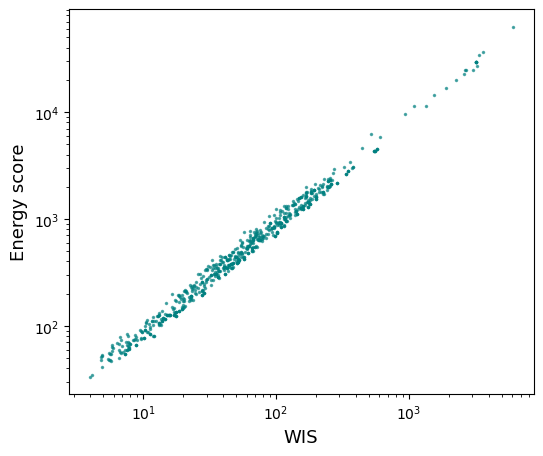

In [67]:
fig, axes = plt.subplots(figsize=(6, 5))
rd = 4
es = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl')

wisdf = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 

cmap = plt.get_cmap('Set2', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt = ['MOBS_NEU-GLEAM_FLU',  'NIH-Flu_TS',  'USC-SIkJalpha']

i=0
for model in modelsfilt:
    wis = wisdf[wisdf.Model == model]

    esmod = es[es.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


    #plt.loglog(allscores.WIS, allscores.energyscore,'.',color=colors[i],markersize=4, label = model)
    
    plt.loglog(allscores.WIS, allscores.energyscore,'.',color='teal', markersize=3, alpha=.6)
    
    i+=1
    
plt.xlabel('WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)


#plt.legend(title='Model')

plt.savefig('../energyscore_wis_flu521.pdf')
plt.show()

compare normalized energy scores between models and scenarios

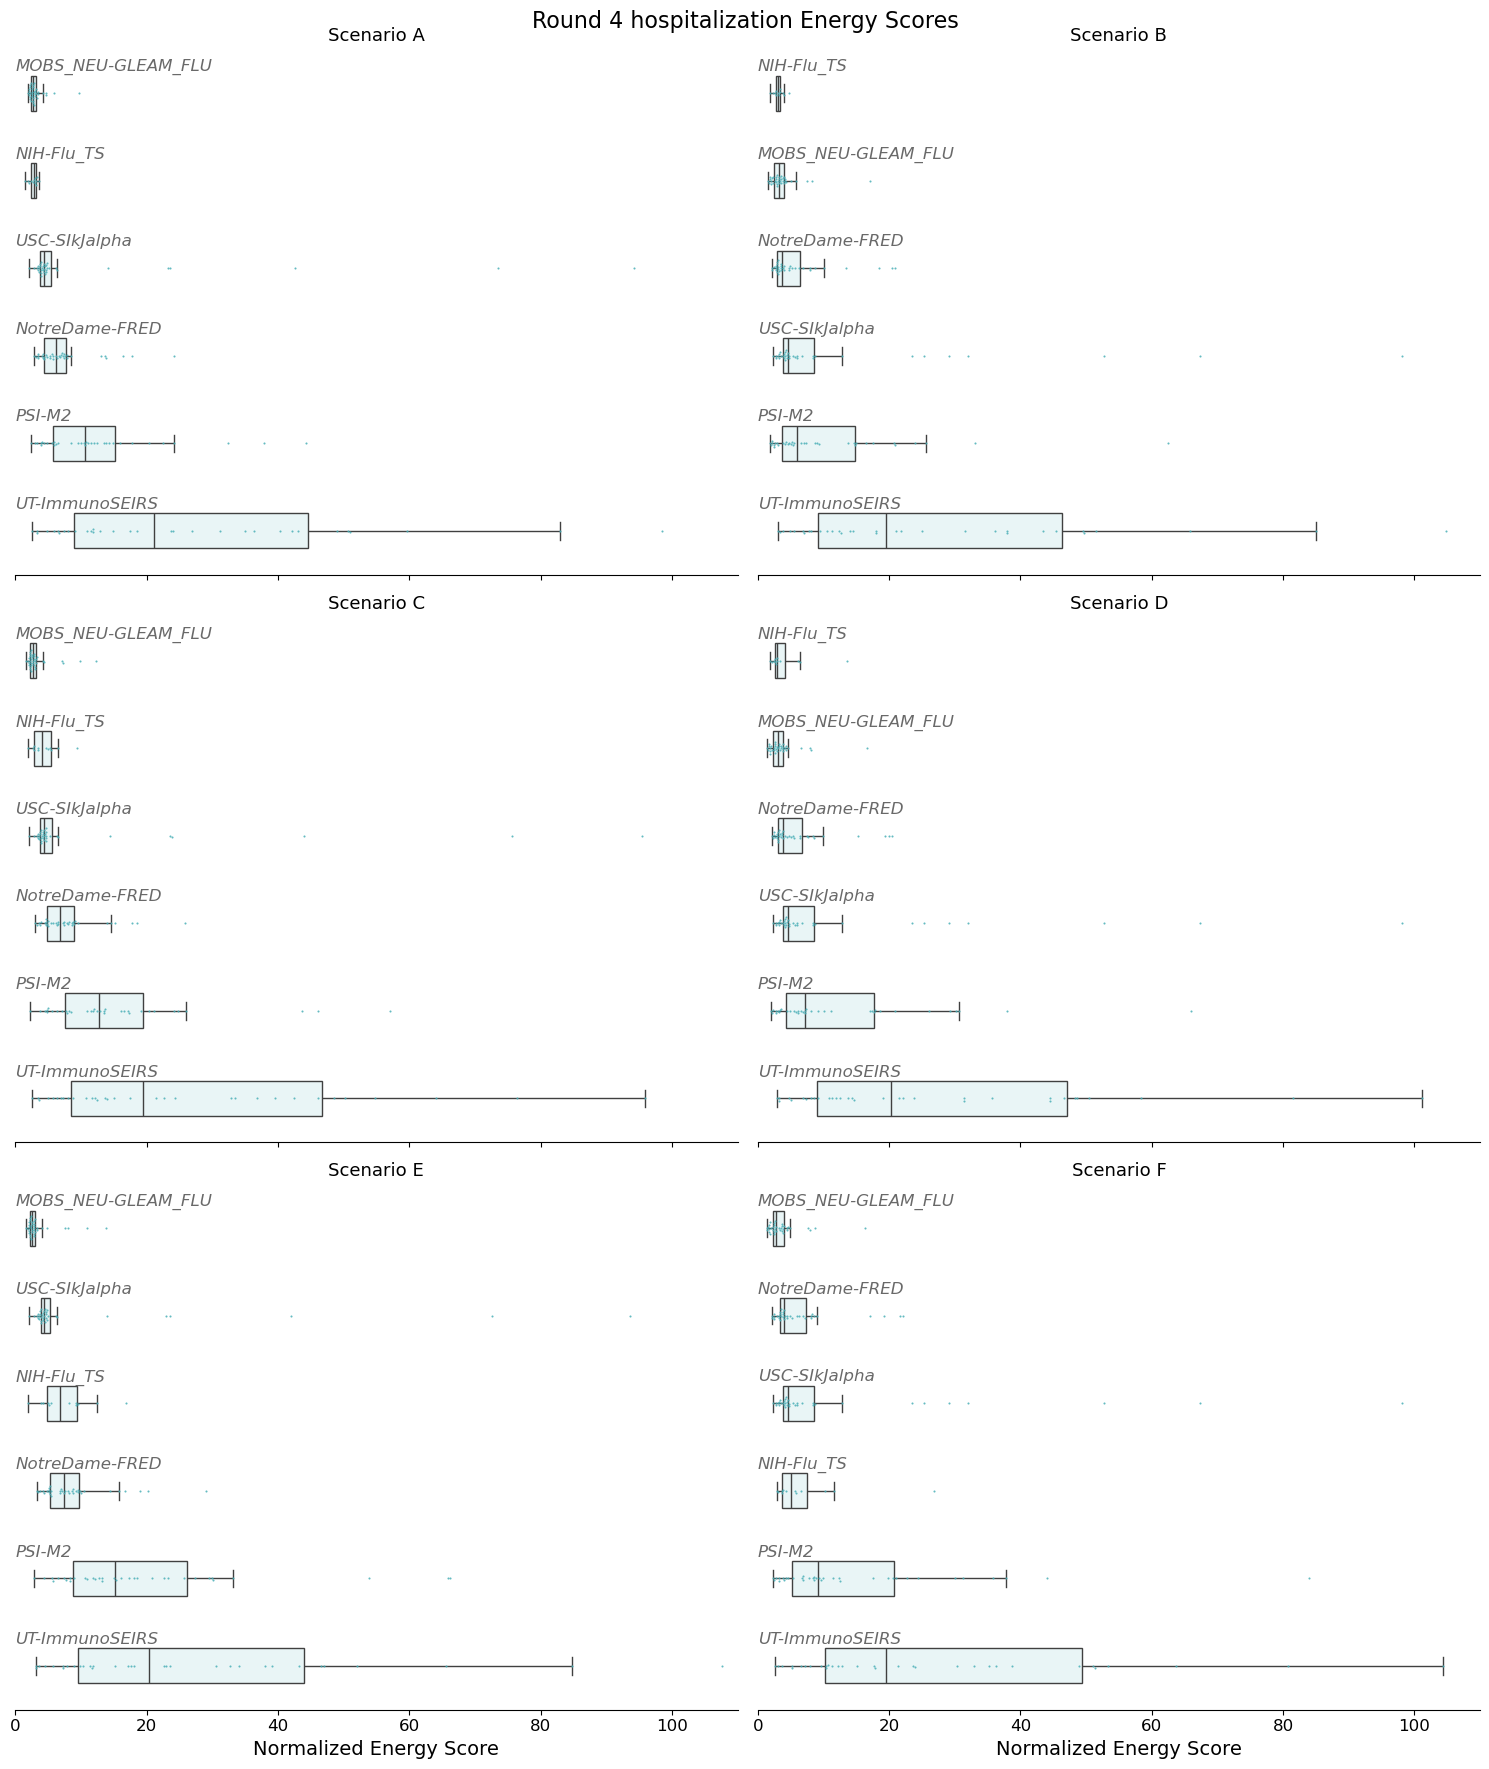

In [36]:
fig = plt.subplots(3,2,figsize=(15,18), sharex=True)

j=1
for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    esdf = energyscoresdf_norm[energyscoresdf_norm.Label == 'Scenario ' + scen]

    my_order = esdf.groupby(by=['Model'])['energyscore'].median().sort_values(ascending=True).index
    g = sns.boxplot(x='energyscore', y='Model', data=esdf,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='energyscore', y='Model', data=esdf,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.5, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Normalized Energy Score')
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.01,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.xlim([0,110]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

plt.suptitle('Round 4 hospitalization Energy Scores', fontsize=16)
plt.tight_layout()
#plt.savefig('energyscore_dist_hosp_rd17.pdf')
plt.show()


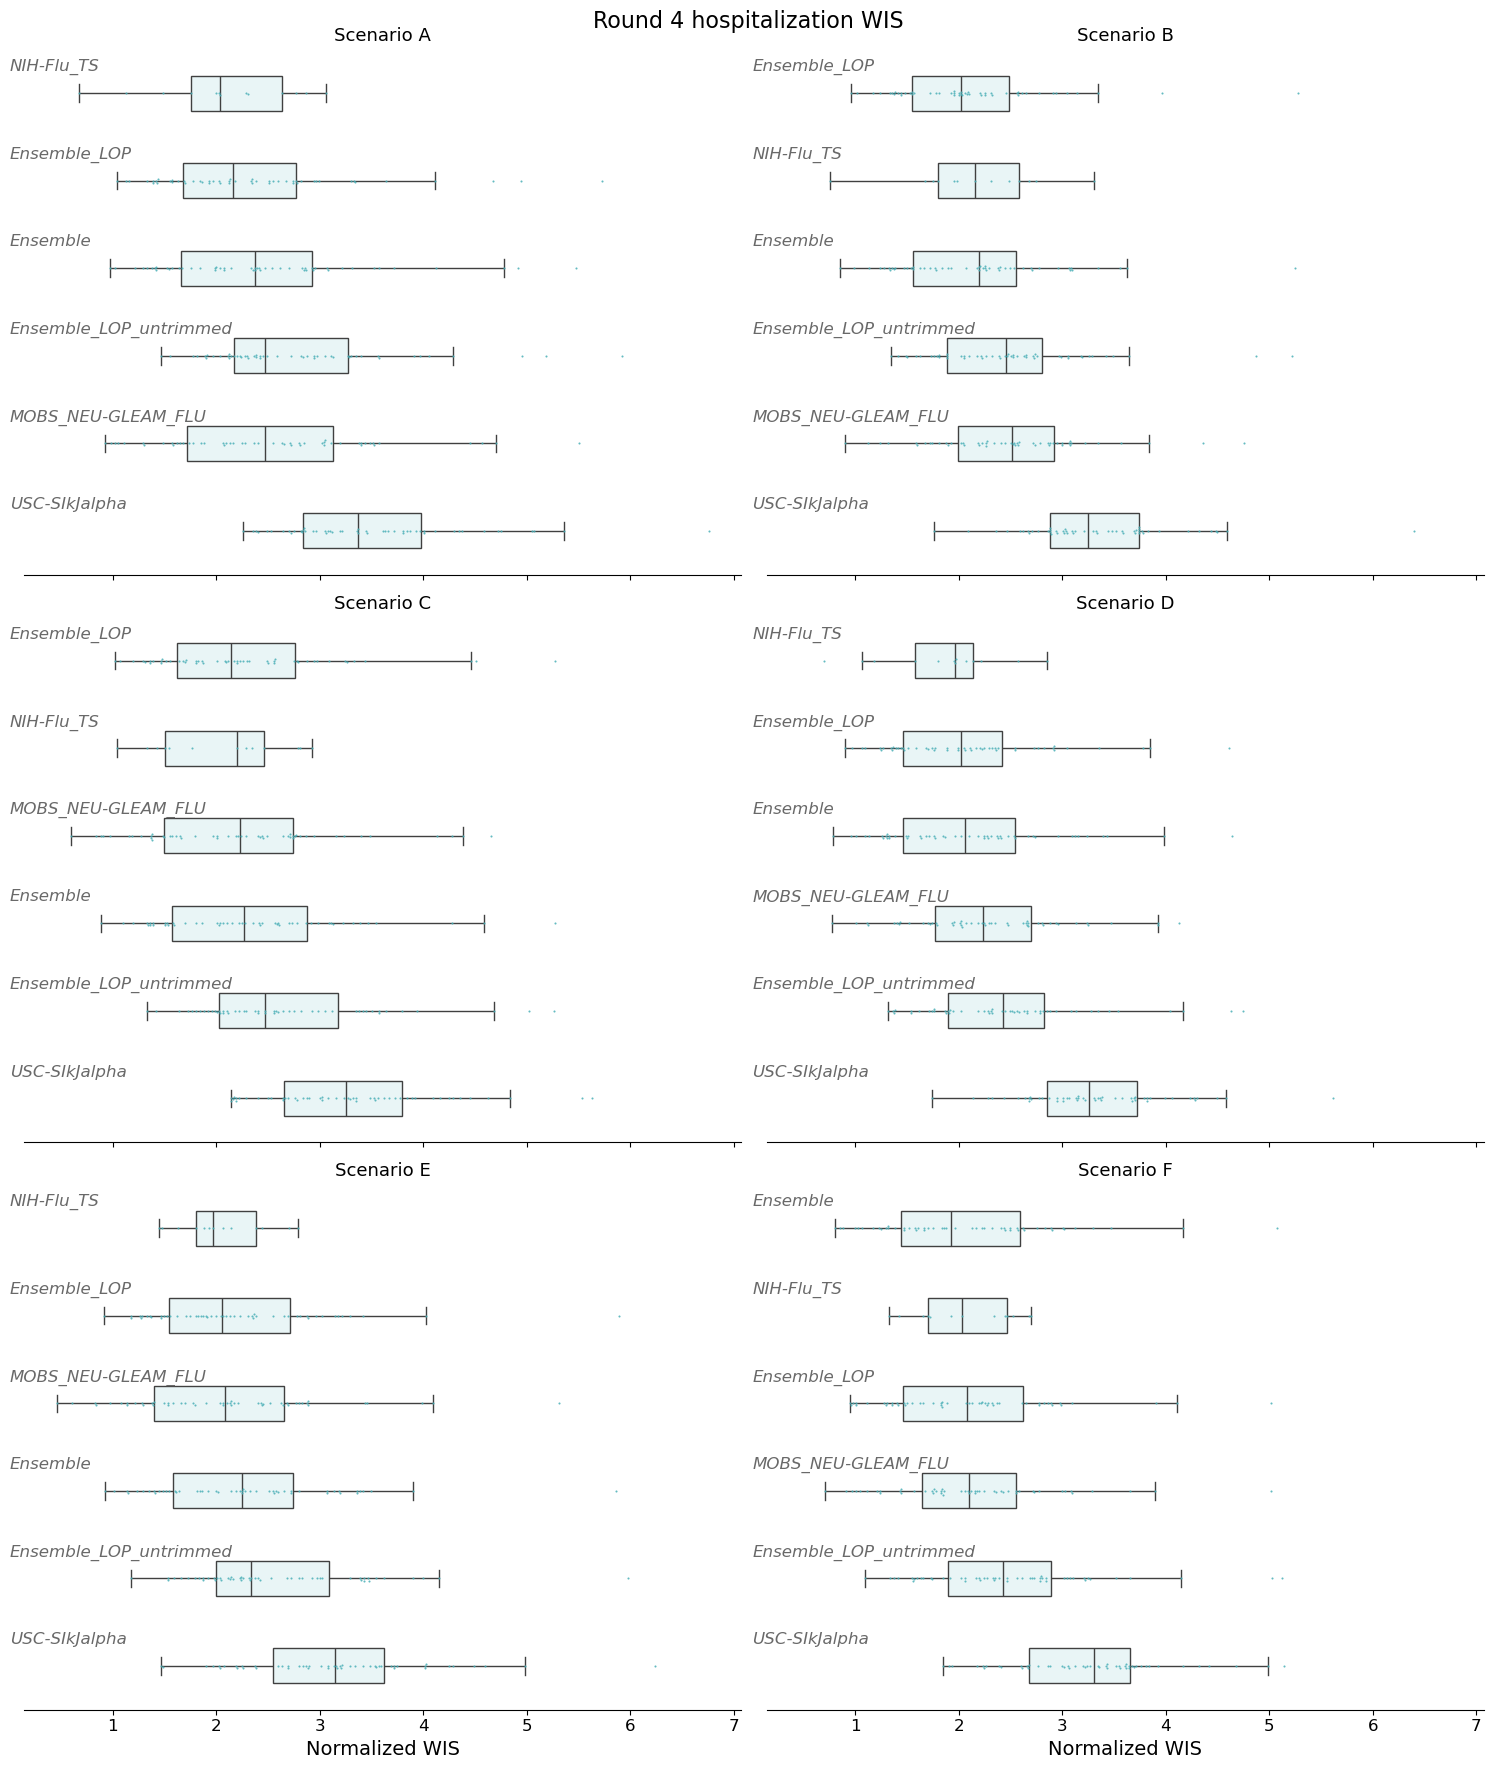

In [37]:
fig = plt.subplots(3,2,figsize=(15,18), sharex=True)

j=1
for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    wisdf = wisnormdf[wisnormdf.Label == 'Scenario ' + scen]

    my_order = wisdf.groupby(by=['Model'])['WISavg'].median().sort_values(ascending=True).index
    g = sns.boxplot(x='WISavg', y='Model', data=wisdf,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='WISavg', y='Model', data=wisdf,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.5, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Normalized WIS', fontsize=14)
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.01,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

   # plt.xlim([0,110]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

plt.suptitle('Round 4 hospitalization WIS', fontsize=16)
plt.tight_layout()
#plt.savefig('energyscore_dist_hosp_rd17.pdf')
plt.show()

# Trajectory ensemble

lump all trajectories together and calculate energy score for each location/scenario

In [38]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
loclist = list(predictionsall.location.unique())


for loc in loclist:
    if loc in ['60','66','69', '72', '78']:
        continue
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsall.location == location) & \
                                    (predictionsall.target == 'inc ' + target)  & \
                                    (predictionsall.target_end_date <= max_date) & \
                                    (predictionsall.target_end_date >= start_week)]

        # get observations
        observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        observations = observations[(observations['date'] >= start_week) & \
                                    (observations['date'] <= max_date)]   

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        y = np.array(observations.value)
        X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

        ES = energyscore(np.array(X),y)
        
        if loc == 'US':
            loc_conv = loc
        elif int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                            'target':target, 'energyscore': ES}, index=[0])

        energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')


In [39]:
energyscoresdf

,Label,location,target,energyscore,abbreviation,location_name,population
0,Scenario A,6,hosp,2408.186334,CA,California,39512223
1,Scenario B,6,hosp,2085.438587,CA,California,39512223
2,Scenario C,6,hosp,3243.165682,CA,California,39512223
3,Scenario D,6,hosp,2444.652925,CA,California,39512223
4,Scenario E,6,hosp,4044.816078,CA,California,39512223
...,...,...,...,...,...,...,...
307,Scenario B,56,hosp,84.160215,WY,Wyoming,578759
308,Scenario C,56,hosp,83.395302,WY,Wyoming,578759
309,Scenario D,56,hosp,82.510690,WY,Wyoming,578759
310,Scenario E,56,hosp,85.894929,WY,Wyoming,578759


In [40]:
energyscoresdf.to_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")

create plots comparing energy score of trajectory ensemble with WIS of submitted SMH ensemble models

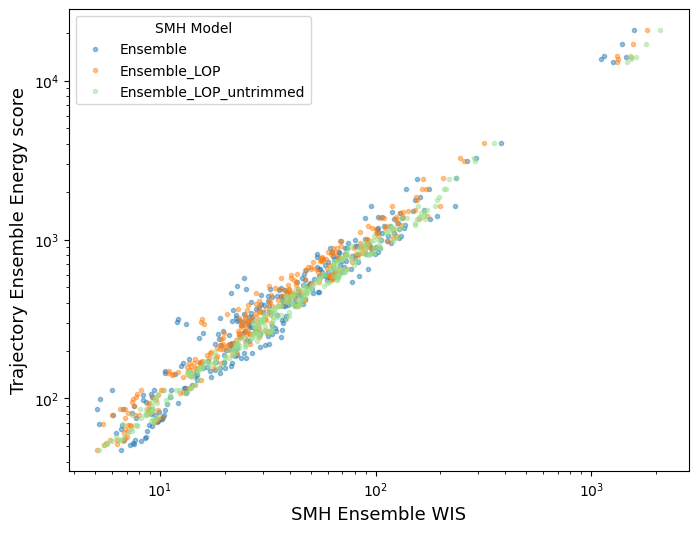

In [41]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17
es = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")

wisdf = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    wis = wisdf[wisdf.Model == model]

    esmod = es

    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.', alpha=.45,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('SMH Ensemble WIS', fontsize=13)
plt.ylabel('Trajectory Ensemble Energy score', fontsize=13)


plt.legend(title='SMH Model')

#plt.savefig('energyscore_wis_raw.pdf')
plt.show()


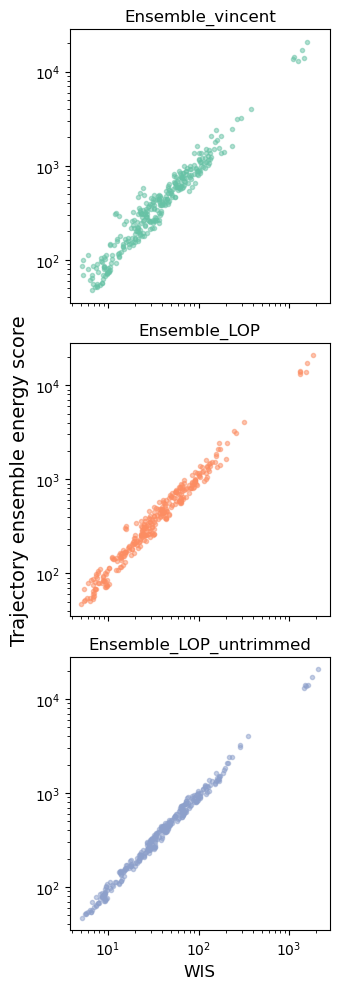

In [76]:
# energy score plot
fig, axes = plt.subplots(3,1,figsize=(3.5, 10), sharex=True, sharey=True)
rd = 4

cmap = plt.get_cmap('Set2', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

es = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")
wisdf = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 


i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    plt.subplot(3,1,i+1)
    wis = wisdf[wisdf.Model == model]
    esmod = es.copy()
    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])

    plt.loglog(allscores.WIS, allscores.energyscore,'.', alpha=.5,color = colors[i], label = model)
    
    i+=1
    
    if i==3:
        plt.xlabel('WIS', fontsize=12)
    
    if i == 2:
        plt.ylabel('Trajectory ensemble energy score', fontsize=14)

    if model=='Ensemble':
        plt.title(model+'_vincent')
    else:
        plt.title(model )

plt.tight_layout()
plt.savefig('energyscore_wis_ensemble_disagg_521.pdf')
plt.show()


standardized rank plots comparing energy score and WIS models

In [ ]:
modelmap = {}

In [43]:
es_ensemble = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")
es_ensemble['Model'] = 'Trajectory ensemble'
es_models = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

es_all = pd.concat([es_models, es_ensemble])

# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = 1 - rank.index(model)/(len(rank)-1)

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']) 


In [395]:
dfrankallenergyscore

,Model,location,Standard_Rank,target,Label
0,UT-ImmunoSEIRS,1,1.000000,hosp,Scenario A
1,Trajectory ensemble,1,0.800000,hosp,Scenario A
2,NotreDame-FRED,1,0.600000,hosp,Scenario A
3,MOBS_NEU-GLEAM_FLU,1,0.400000,hosp,Scenario A
4,USC-SIkJalpha,1,0.200000,hosp,Scenario A
...,...,...,...,...,...
1939,Trajectory ensemble,US,0.666667,hosp,Scenario F
1940,PSI-M2,US,0.500000,hosp,Scenario F
1941,MOBS_NEU-GLEAM_FLU,US,0.333333,hosp,Scenario F
1942,UT-ImmunoSEIRS,US,0.166667,hosp,Scenario F


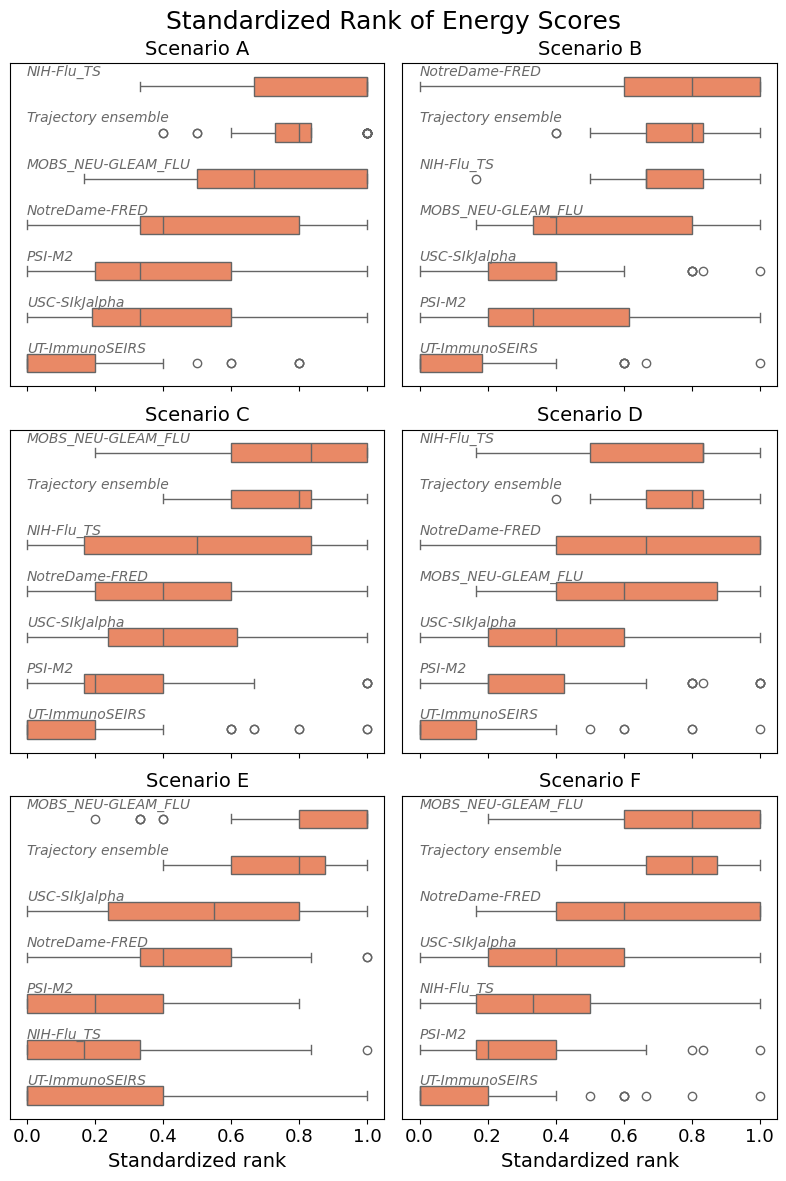

In [44]:
plt.subplots(3,2,figsize=(8,12), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1

#dfrankallenergyscore = dfrankallenergyscore[(dfrankallenergyscore.Model != 'UNCC-hierbin') &\
#                                            (dfrankallenergyscore.Model != 'UVA-EpiHiper') &\
 #                                           (dfrankallenergyscore.Model != 'USC-SIkJalpha')]
for scenario in dfrankallenergyscore.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallenergyscore[dfrankallenergyscore.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    ges = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = 'coral', width=0.4)
    
    ges.set(yticklabels=[])
    ges.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        ges.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=14)
    else:
        ges.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.22, mod, fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('Standardized Rank of Energy Scores', fontsize=18)
plt.tight_layout()
#plt.savefig('standardrank_energyscore.pdf')
plt.show()


In [45]:
# standardized rank WIS

dfa =  pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WIS')

        rank = list(filt.Model)
        for model in rank:
            rankval = 1 - rank.index(model)/(len(rank)-1)

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)


dfrankallwis = dfrank.reset_index()
dfrankallwis = dfrankallwis.drop(columns=['index']) 

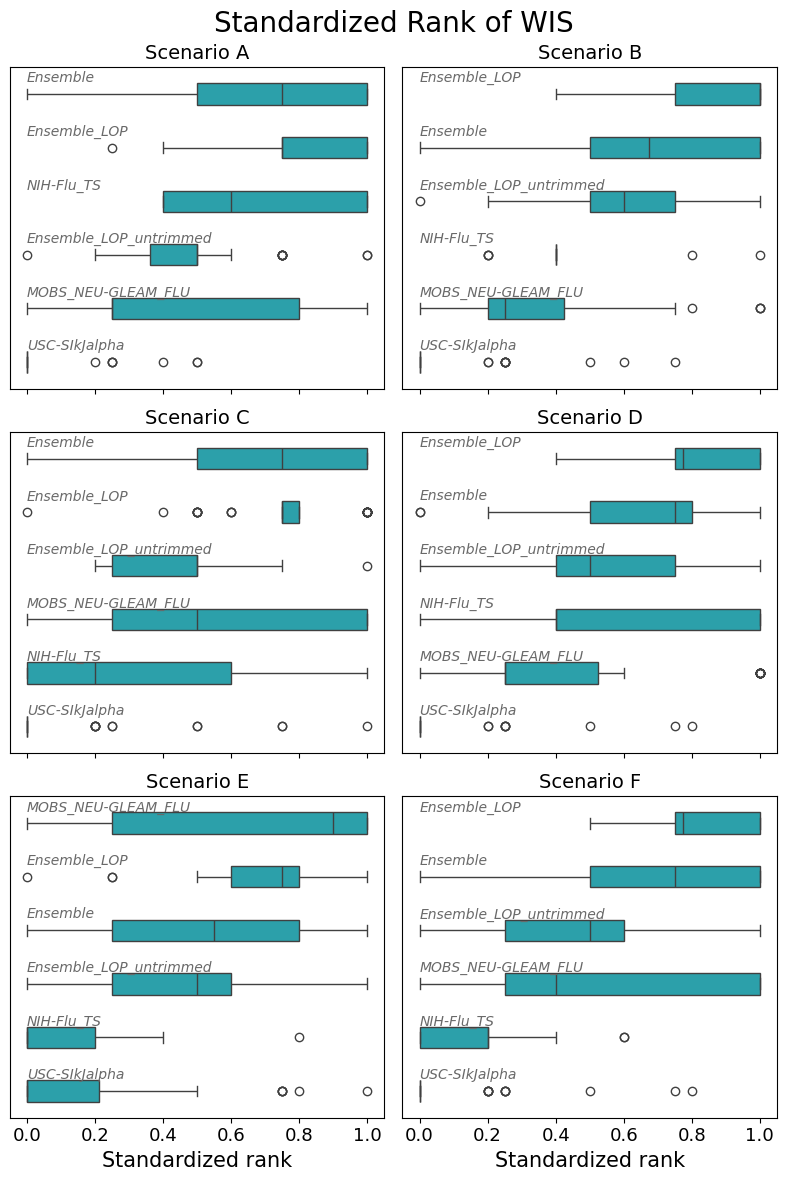

In [46]:
plt.subplots(3,2,figsize=(8,12), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in dfrankallwis.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallwis[dfrankallwis.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    g = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=15)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.22, mod, fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('Standardized Rank of WIS', fontsize=20)
plt.tight_layout()
#plt.savefig('standardrank_WIS.pdf')
plt.show()


time series envelope plots of ensemble models

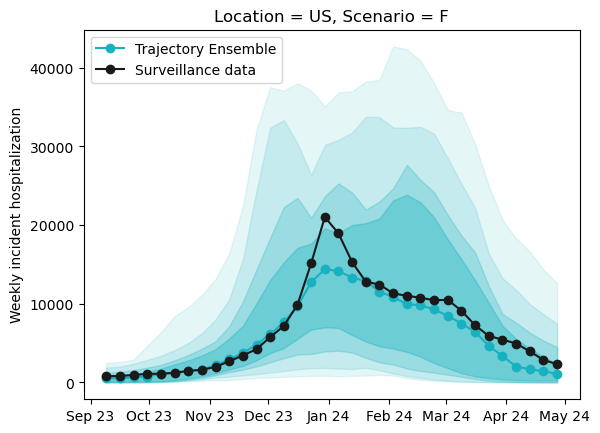

In [47]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]   

fig, axes = plt.subplots(1,1)


scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    

predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                              (predictionsall.location == location) & \
                              (predictionsall.target == 'inc ' + target)  & \
                              (predictionsall.target_end_date <= max_date) & \
                              (predictionsall.target_end_date >= start_week)]

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='#17B1BF', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='#17B1BF', alpha=1,
                               label=fr"Trajectory Ensemble")
    
observations = format_observations(location=location)

axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes)

#set y axis 
axes.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization")
    
plt.legend(loc='upper left')

plt.title(f'Location = {location}, Scenario = {scenario}')

plt.show()

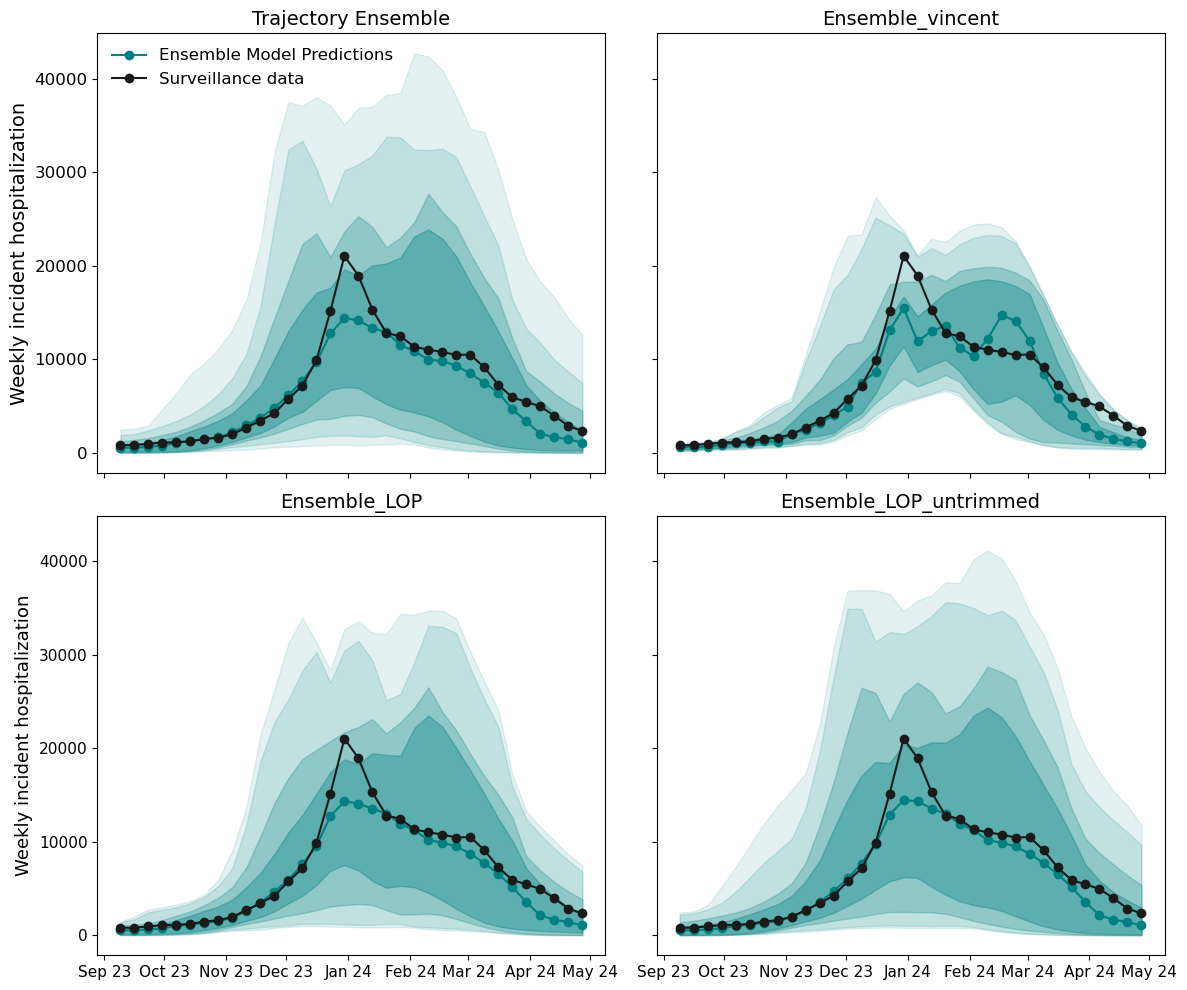

In [82]:
# all ensemble models

fig, axes = plt.subplots(2,2,figsize=(12,10), sharey=True, sharex = True)

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

plt.subplot(2,2,1)

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                              (predictionsall.location == location) & \
                              (predictionsall.target == 'inc ' + target)  & \
                              (predictionsall.target_end_date <= max_date) & \
                              (predictionsall.target_end_date >= start_week)]

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='teal', alpha=1,
                               label=fr"Ensemble Model Predictions")
    
observations = format_observations(location=location)

axes[0][0].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
    
set_date_axis_fmt(axes[0][0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#set y axis 
plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=14)
plt.title('Trajectory Ensemble', fontsize=14)
    
plt.legend(fontsize=12, loc = 'upper left', frameon=False)

i=2 

for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    plt.subplot(2,2,i)
    
    predictions = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    predictions = predictions[(predictions.output_type == 'quantile') & (predictions.age_group == '0-130')]
    predictions['output_type_id'] = predictions['output_type_id'].astype("float")
    predictions['Model'] = model
    
    
    if i == 2:
        a = 0
        b = 1
    elif i ==3:
        a = 1
        b = 0
    else:
        a=1
        b=1
    

    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

    predictions["scenario_letter"] = predictions.scenario_id.str[0]
    predictions.drop(predictions[predictions.output_type == 'point'].index, inplace=True)

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death_new'
    else:
        target_obs = target
        
    observations = format_observations(location=location)
    
    target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

    predictions = predictions[predictions.location == location]
    predictions = predictions[(predictions['target'].isin(target_prediction_list))]


    predictions = predictions[(predictions.scenario_letter == scenario) & \
                              (predictions.target_end_date <= max_date)]

    t = predictions.target_end_date.unique()

    intervals = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
    #intervals = [(.35, .65)]
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = list(predictions.groupby('horizon')['value'].quantile(q_low))
        pred_upp = list(predictions.groupby('horizon')['value'].quantile(q_upp))
        axes[a][b].fill_between(t,pred_upp,pred_low, color='teal', alpha=alpha)

    #point estimate
    pred_point = list(predictions.groupby('horizon')['value'].quantile(.5))
    if len(pred_point) > 0:
        axes[a][b].plot(t,pred_point,'-o',color='teal', label = model)

    #plot surveillance
    axes[a][b].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    #set x axis
    set_date_axis_fmt(axes[a][b])
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)


    #set y axis 
    if i ==3:
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}", fontsize=13)

    #plt.legend()
    
    i += 1
    
    if model == 'Ensemble':
        plt.title('Ensemble_vincent', fontsize=14)
    else:
        plt.title(model, fontsize=14)

#plt.suptitle(f'Location = {location}, Scenario = {scenario}', fontsize=16) 
plt.tight_layout()

plt.savefig('../figs/ensemblepredictions_521.pdf')

plt.show()

# calculate WIS from trajectory quantiles

for individual models:

In [49]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in modelsall:

    for loc in loclist:
    
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= max_date) & \
                                        (predictionsall.target_end_date >= start_week) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue
            
            observations = format_observations(location=location)

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   


wisdf_traj = pd.merge(wisdf_traj, locations, how = 'inner', on = 'location')


#samplewisdf.to_pickle(f'./samplewis/wis_ensemble_rd17_hosp_trajectory.pkl')



In [50]:
wisdf_traj

,Model,Label,location,WIS,target,abbreviation,location_name,population
0,CADPH-FluCAT,Scenario A,6,431.443223,hosp,CA,California,39512223
1,CADPH-FluCAT,Scenario B,6,161.022418,hosp,CA,California,39512223
2,CADPH-FluCAT,Scenario C,6,490.455326,hosp,CA,California,39512223
3,CADPH-FluCAT,Scenario D,6,188.993334,hosp,CA,California,39512223
4,CADPH-FluCAT,Scenario E,6,619.720487,hosp,CA,California,39512223
...,...,...,...,...,...,...,...,...
1651,UT-ImmunoSEIRS,Scenario B,56,15.647571,hosp,WY,Wyoming,578759
1652,UT-ImmunoSEIRS,Scenario C,56,15.378024,hosp,WY,Wyoming,578759
1653,UT-ImmunoSEIRS,Scenario D,56,17.211169,hosp,WY,Wyoming,578759
1654,UT-ImmunoSEIRS,Scenario E,56,16.052321,hosp,WY,Wyoming,578759


In [51]:
wisdf_traj.to_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")

plots looking at wis calculated from quantiles of individual trajectories

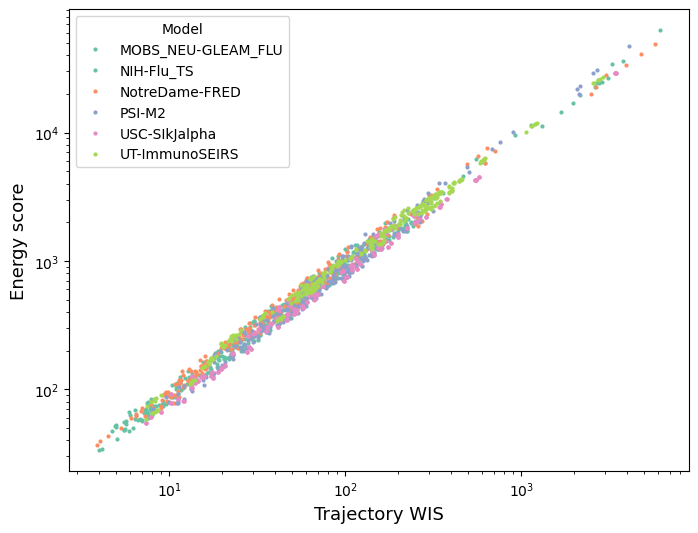

In [92]:
fig, axes = plt.subplots(figsize=(8, 6))
rd = 4
es = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl')

wisdf = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt =['MOBS_NEU-GLEAM_FLU',  'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']

i=0
for model in modelsfilt:
    wis = wisdf[wisdf.Model == model]

    esmod = es[es.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.',color=colors[i],markersize=4, label = model)
    
    i+=1
    
plt.xlabel('Trajectory WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)


plt.legend(title='Model')

#plt.savefig('')
plt.show()

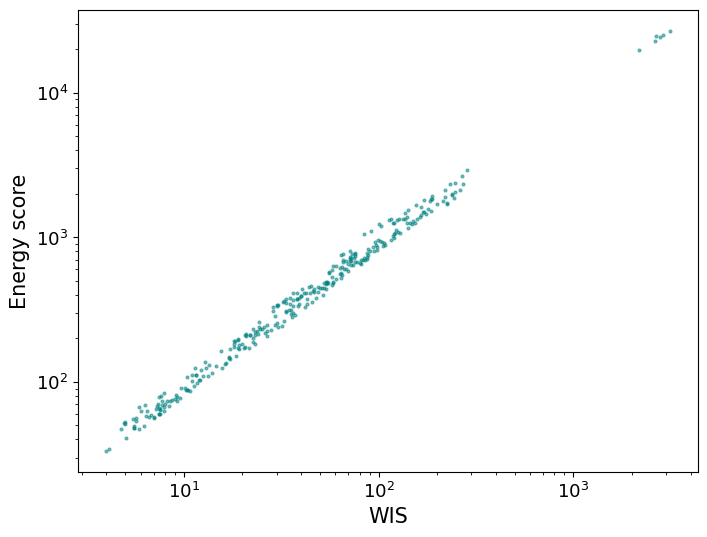

In [98]:
fig, axes = plt.subplots(figsize=(8, 6))
rd = 4
es = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl')

wisdf = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

modelsfilt =['MOBS_NEU-GLEAM_FLU']

i=0
for model in modelsfilt:
    wis = wisdf[wisdf.Model == model]

    esmod = es[es.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.',color='teal',markersize=4, label = model, alpha=.5)
    
    i+=1
    
plt.xlabel('WIS', fontsize=15)
plt.ylabel('Energy score', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


#plt.legend(title='Model')

plt.savefig('../figs/ESvsWIS_fromtraj_81.pdf')
plt.show()

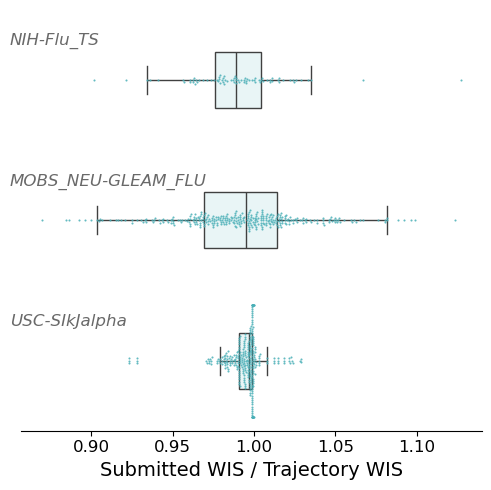

In [53]:
fig = plt.subplots(1,1,figsize=(5,5), sharex=True)

j=1

ax = plt.subplot(1,1,j)

wissubmit = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 
wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl")
wistraj = wistraj.rename(columns={'WIS':'WIS_traj'})

wismerge = pd.merge(wissubmit, wistraj, on = ['Model', 'Label', 'location', 'target'])
wismerge['wisratio'] = wismerge['WIS'] / wismerge['WIS_traj']

my_order = wismerge.groupby(by=['Model'])['wisratio'].median().sort_values(ascending=True).index
g = sns.boxplot(x='wisratio', y='Model', data=wismerge,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))


sns.swarmplot(x='wisratio', y='Model', data=wismerge,order=my_order,color = "#49AFB7",
              alpha = .85,size=1.5, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

plt.xlabel('Submitted WIS / Trajectory WIS', fontsize=14)
plt.xticks(fontsize=12)


a = 0
for mod in list(my_order):
    plt.text(.85,a-.25, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# plt.xlim([0,110]) # cuts off some outliers

plt.tight_layout()
#plt.savefig(' ')
plt.show()

calculate WIS of trajectory ensemble

In [54]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

wisdf_enstraj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
loclist = list(predictionsall.location.unique())

for loc in loclist:

    if loc in ['60','66','69', '72', '78']:
        continue
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsall.location == location) & \
                                    (predictionsall.target == 'inc ' + target)  & \
                                    (predictionsall.target_end_date <= max_date) & \
                                    (predictionsall.target_end_date >= start_week)]

        # get observations
        observations = format_observations(location=location)

        y = np.array(observations.value)
        X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                        for i in predictionsfilt.trajectory_id.unique()])

        quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                    0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

        # get quantiles
        Q = np.quantile(X,quantiles,axis=0)

        # calculate WIS
        WIS = np.zeros(X.shape[1])
        for i in range(len(quantiles) // 2):
            interval_range = 100*(quantiles[-i-1]-quantiles[i])
            alpha = 1-(quantiles[-i-1]-quantiles[i])
            IS = interval_score(y,Q[i],Q[-i-1],interval_range)
            WIS += IS['interval_score']*alpha/2
        WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

        WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

        if loc == 'US':
            loc_conv = loc
        elif int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        # save into dataframe
            newrow = pd.DataFrame({'Model':'Trajectory Ensemble' , 'Label': 'Scenario '+ scenario,
                                   'location':loc_conv, 'WIS':WIS, 'target':target}, index=[0])

            wisdf_enstraj = pd.concat([wisdf_enstraj, newrow])


wisdf_enstraj = wisdf_enstraj.reset_index()
wisdf_enstraj = wisdf_enstraj.drop(columns=['index'])   

wisdf_enstraj = pd.merge(wisdf_enstraj, locations, how = 'inner', on = 'location')


In [55]:
wisdf_enstraj

,Model,Label,location,WIS,target,abbreviation,location_name,population
0,Trajectory Ensemble,Scenario A,10,9.221074,hosp,DE,Delaware,973764
1,Trajectory Ensemble,Scenario B,10,8.170133,hosp,DE,Delaware,973764
2,Trajectory Ensemble,Scenario C,10,9.623200,hosp,DE,Delaware,973764
3,Trajectory Ensemble,Scenario D,10,8.619206,hosp,DE,Delaware,973764
4,Trajectory Ensemble,Scenario E,10,9.895937,hosp,DE,Delaware,973764
...,...,...,...,...,...,...,...,...
259,Trajectory Ensemble,Scenario B,56,9.265634,hosp,WY,Wyoming,578759
260,Trajectory Ensemble,Scenario C,56,9.024401,hosp,WY,Wyoming,578759
261,Trajectory Ensemble,Scenario D,56,9.122358,hosp,WY,Wyoming,578759
262,Trajectory Ensemble,Scenario E,56,9.248823,hosp,WY,Wyoming,578759


In [56]:
wisdf_enstraj.to_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp_521.pkl")

plots looking at WIS generated from quantiles of trajectory ensemble

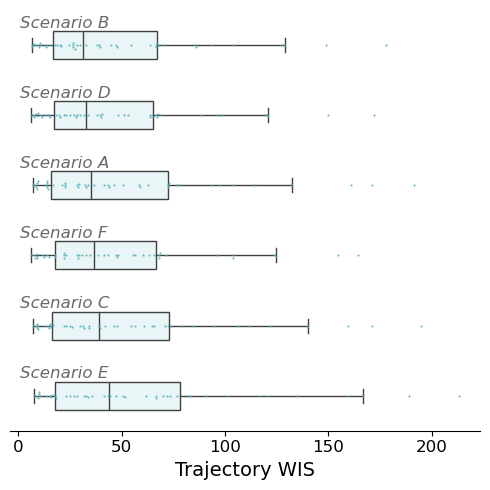

In [57]:
fig = plt.subplots(1,1,figsize=(5,5), sharex=True)

j=1

ax = plt.subplot(1,1,j)

wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp_521.pkl")

my_order = wistraj.groupby(by=['Label'])['WIS'].median().sort_values(ascending=True).index
g = sns.boxplot(x='WIS', y='Label', data=wistraj,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))


sns.swarmplot(x='WIS', y='Label', data=wistraj,order=my_order,color = "#49AFB7",
              alpha = .85,size=1.5, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

plt.xlabel('Trajectory WIS', fontsize=14)
plt.xticks(fontsize=12)


a = 0
for mod in list(my_order):
    plt.text(.85,a-.25, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# plt.xlim([0,110]) # cuts off some outliers

plt.tight_layout()
#plt.savefig(' ')
plt.show()

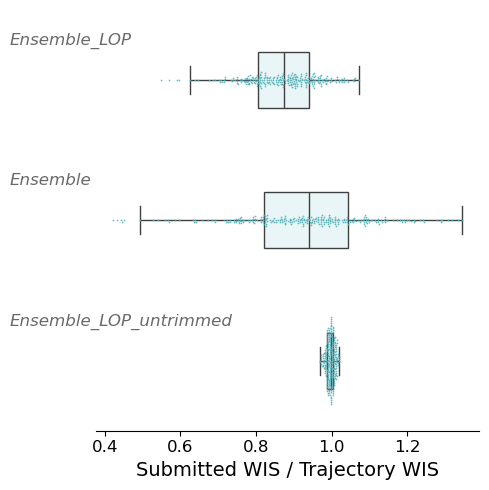

In [58]:
fig = plt.subplots(1,1,figsize=(5,5), sharex=True)

j=1

ax = plt.subplot(1,1,j)

wissubmit = pd.read_pickle('/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_submitted_rd4_hosp_521.pkl') 
wissubmit = wissubmit[wissubmit.Model.isin(['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed'])]

wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp_521.pkl")
wistraj = wistraj.rename(columns={'WIS':'WIS_traj'})

wismerge = pd.merge(wissubmit, wistraj, on = ['Label', 'location', 'target'])
wismerge['wisratio'] = wismerge['WIS'] / wismerge['WIS_traj']

my_order = wismerge.groupby(by=['Model_x'])['wisratio'].median().sort_values(ascending=True).index
g = sns.boxplot(x='wisratio', y='Model_x', data=wismerge,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))


sns.swarmplot(x='wisratio', y='Model_x', data=wismerge,order=my_order,color = "#49AFB7",
              alpha = .85,size=1.25, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

plt.xlabel('Submitted WIS / Trajectory WIS', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)


a = 0
for mod in list(my_order):
    plt.text(.15,a-.25, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# plt.xlim([0,110]) # cuts off some outliers

plt.tight_layout()
#plt.savefig('')
plt.show()

In [1]:
len( ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']
)

10

In [26]:
models = ['MOBS_NEU-GLEAM_FLU', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F',
            'Trajectory Ensemble': 'Trajectory Ensemble'}

In [14]:
# standardized rank for energy score poster 
target='hosp'
es_ensemble = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")
es_ensemble['Model'] = 'Trajectory Ensemble'
es_models = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

es_all = pd.concat([es_ensemble, es_models])

# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = 1 - rank.index(model)/(len(rank)-1)

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']) 


In [15]:
dfrankallenergyscore

,Model,location,Standard_Rank,target,Label
0,USC-SIkJalpha,6,1.000000,hosp,Scenario A
1,NIH-Flu_TS,6,0.833333,hosp,Scenario A
2,MOBS_NEU-GLEAM_FLU,6,0.666667,hosp,Scenario A
3,Trajectory ensemble,6,0.500000,hosp,Scenario A
4,PSI-M2,6,0.333333,hosp,Scenario A
...,...,...,...,...,...
1939,Trajectory ensemble,56,0.800000,hosp,Scenario F
1940,MOBS_NEU-GLEAM_FLU,56,0.600000,hosp,Scenario F
1941,USC-SIkJalpha,56,0.400000,hosp,Scenario F
1942,PSI-M2,56,0.200000,hosp,Scenario F


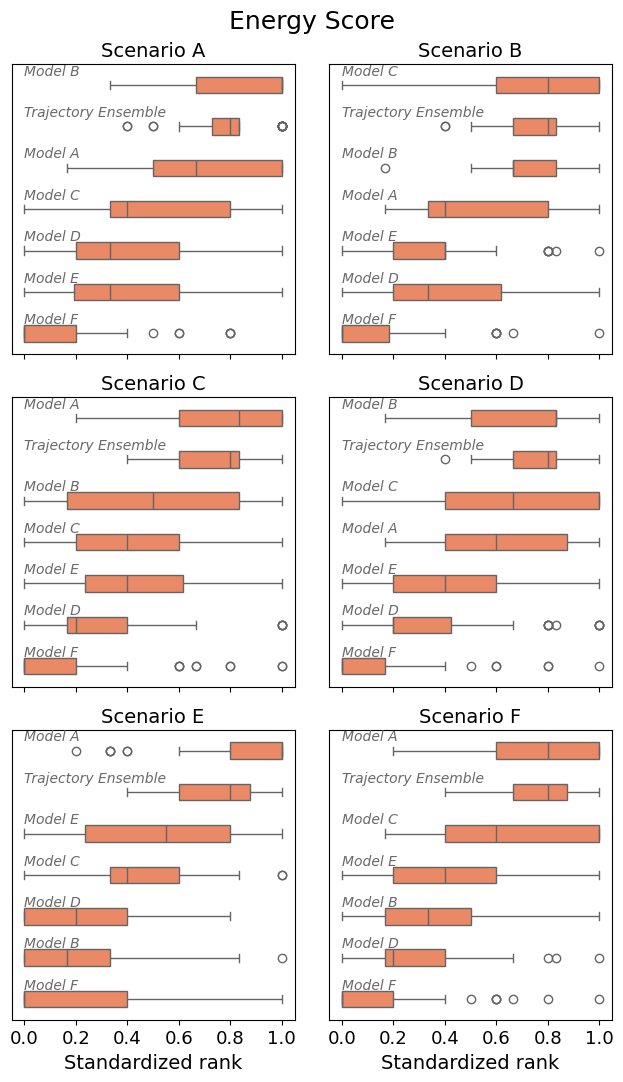

In [19]:
plt.subplots(3,2,figsize=(6.5,11), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1

#dfrankallenergyscore = dfrankallenergyscore[(dfrankallenergyscore.Model != 'UNCC-hierbin') &\
#                                            (dfrankallenergyscore.Model != 'UVA-EpiHiper') &\
 #                                           (dfrankallenergyscore.Model != 'USC-SIkJalpha')]
for scenario in dfrankallenergyscore.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallenergyscore[dfrankallenergyscore.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    ges = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = 'coral', width=0.4)
    
    ges.set(yticklabels=[])
    ges.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        ges.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=14)
    else:
        ges.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('Energy Score', fontsize=18)
plt.tight_layout()
plt.savefig('../standardrank_energyscore_717.pdf')
plt.show()


In [23]:
# standardized rank WIS

dfa =  pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl") 
dfens = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp_521.pkl") 

dfa = pd.concat([dfa, dfens])
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

dfa = dfa[~dfa['Model'].isin(singleloc_models)]


dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WIS')

        rank = list(filt.Model)
        for model in rank:
            rankval = 1 - rank.index(model)/(len(rank)-1)

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)


dfrankallwis = dfrank.reset_index()
dfrankallwis = dfrankallwis.drop(columns=['index']) 

In [24]:
dfrankallwis

,Model,location,Standard_Rank,target,Label
0,NIH-Flu_TS,6,1.0,hosp,Scenario A
1,USC-SIkJalpha,6,0.8,hosp,Scenario A
2,MOBS_NEU-GLEAM_FLU,6,0.6,hosp,Scenario A
3,PSI-M2,6,0.4,hosp,Scenario A
4,NotreDame-FRED,6,0.2,hosp,Scenario A
...,...,...,...,...,...
1891,Trajectory Ensemble,56,0.8,hosp,Scenario F
1892,MOBS_NEU-GLEAM_FLU,56,0.6,hosp,Scenario F
1893,UT-ImmunoSEIRS,56,0.4,hosp,Scenario F
1894,PSI-M2,56,0.2,hosp,Scenario F


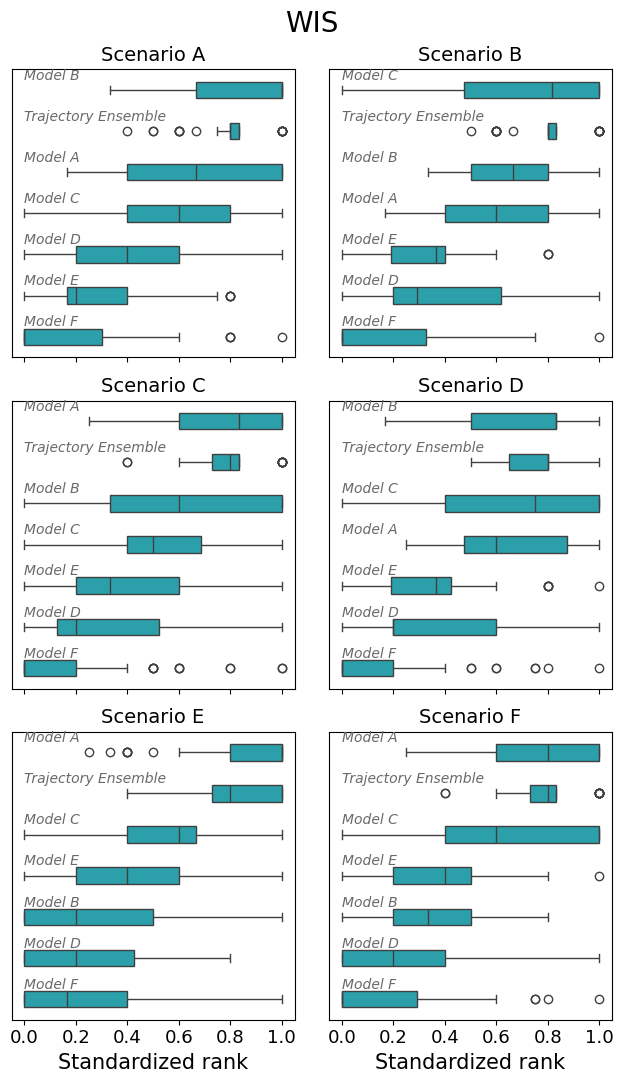

In [28]:
plt.subplots(3,2,figsize=(6.5,11), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in dfrankallwis.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallwis[dfrankallwis.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    g = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=15)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('WIS', fontsize=20)
plt.tight_layout()
plt.savefig('../standardrank_WIS_717.pdf')
plt.show()


# Trajectory vs quantile variability/outcomes

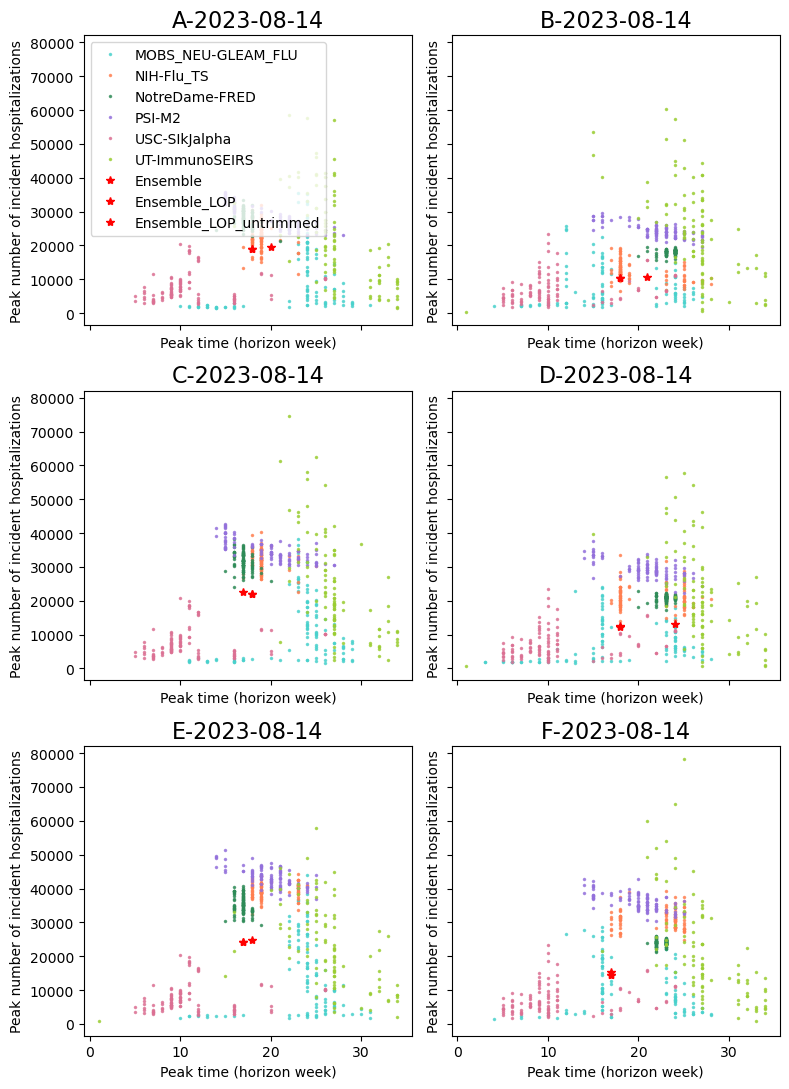

In [64]:
# think about peak timing variability
plt.subplots(3,2,figsize=(8,11), sharex=True, sharey=True)
colors = ['mediumturquoise', 'coral', 'seagreen', 'mediumpurple', 'palevioletred', 'yellowgreen']
i=1
for scenario in predictions_traj.scenario_id.unique():
    plt.subplot(3,2,i)
    plt.title(scenario, fontsize=16)
    j=0
    for model in predictions_traj.Model.unique():


        df = predictions_traj[(predictions_traj.scenario_id==scenario) & \
                              (predictions_traj.Model == model) & (predictions_traj.location =='US')]

        peaktimes = []
        peakmags = []
        for run in df.output_type_id.unique():
            dfrun = df[df.output_type_id == run]

            peak = dfrun[dfrun.value == dfrun.value.max()]

            peaktimes.append(list(peak.horizon)[0])
            peakmags.append(list(peak.value)[0])

        plt.plot(peaktimes, peakmags, '.',markersize=3, alpha=0.75, label= model, color = colors[j])
        j+=1
        
    for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
        predictions = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
        # filter by trajectories and only look at age group with all ages combined
        predictions['output_type_id'] = predictions['output_type_id'].astype("float")
        predictions = predictions[(predictions.output_type == 'quantile') & (predictions.age_group == '0-130') &\
                                  (predictions.scenario_id == scenario) & (predictions.location == 'US') &\
                                 (predictions.output_type_id == 0.5)]
        predictions['Model'] = model
        
        peakens = predictions[predictions.value ==predictions.value.max()]
        peaktimeens = list(peakens.horizon)[0]
        peakmagens = list(peakens.value)[0]
        plt.plot(peaktimeens, peakmagens, '*',markersize=6, alpha=1, label= model, color = 'r')
        

    plt.xlabel('Peak time (horizon week)')
    plt.ylabel('Peak number of incident hospitalizations')
    if i==1:
        plt.legend()
        
    i+=1
    
    
plt.tight_layout()
plt.show()


# Normalization plots

In [99]:
energyscoresdf = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

In [8]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,426.430823,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,410.700957,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,410.799822,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,408.848089,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,421.623785,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,25598.171912,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,27081.777290,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,25498.213156,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,24345.522962,hosp,US,US,328728466


In [17]:
df = observations.drop(columns=['Unnamed: 0', 'weekly_rate']).groupby(['location', 'location_name']).sum()

df.to_csv("/Users/bay.c/Documents/GitHub/energy-score/fludat/observations_sum.csv")

In [100]:
obs_sum = pd.read_csv("/Users/bay.c/Documents/GitHub/energy-score/fludat/observations_sum.csv")

In [135]:
energyscoredf = pd.merge(energyscoresdf, obs_sum, on=['location', 'location_name'])
energyscoredf = energyscoredf[energyscoredf.location != 'US']

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


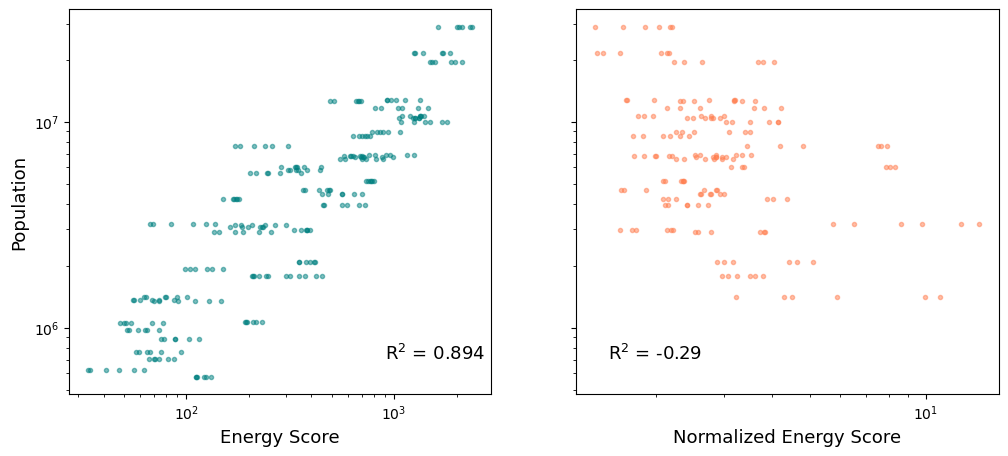

In [145]:
plt.subplots(1,2,figsize=(12,5), sharey= True)


plt.subplot(1,2,1)
energyscoredf = energyscoredf[(energyscoredf.Model == 'MOBS_NEU-GLEAM_FLU') ]
energyscoredfnorm = energyscoredfnorm[(energyscoredfnorm.Model =='MOBS_NEU-GLEAM_FLU') ]

plt.loglog(energyscoredf.energyscore, energyscoredf.population, '.', color='teal', alpha=.5)
plt.xlabel('Energy Score', fontsize=13)
plt.ylabel('Population', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredf.energyscore, energyscoredf.population)
    
plt.text(900,700000, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)

plt.subplot(1,2,2)
plt.loglog(energyscoredfnorm.energyscore, energyscoredfnorm.population, '.', color='coral', alpha=.5)
plt.xlabel('Normalized Energy Score', fontsize=13)
#plt.ylabel('Total number of hospitalizations', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredfnorm.energyscore, energyscoredfnorm.population)
    
plt.text(1.5,700000, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)


plt.savefig('../figs/energyscore_norm_compare_MOBS.pdf')

In [136]:
energyscoresdf_norm =pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_norm_individual_rd4_hosp_521.pkl")



In [137]:
energyscoredfnorm = pd.merge(energyscoresdf_norm, obs_sum, on=['location', 'location_name']).dropna()
energyscoredfnorm = energyscoredfnorm[energyscoredfnorm.location != 'US']

In [129]:
energyscoresdf_norm

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,2.796140,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,2.545872,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,3.157534,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,2.542182,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,3.317210,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,3.312413,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,3.608566,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,3.278241,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,3.155635,hosp,US,US,328728466


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(80, 1200, 'R$^2$ = -0.125')

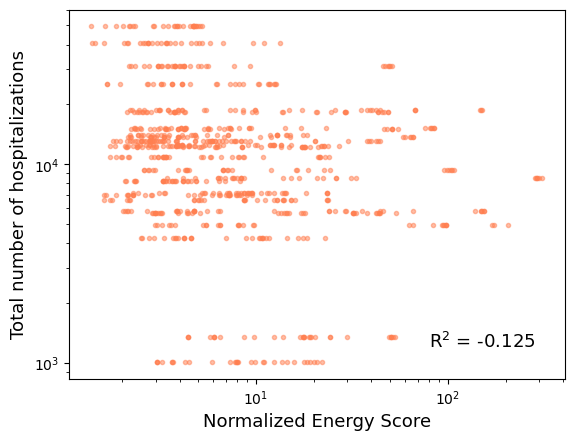

In [89]:
plt.plot(energyscoredfnorm.energyscore, energyscoredfnorm.value, '.', color='coral', alpha=.5)
plt.xlabel('Normalized Energy Score', fontsize=13)
plt.ylabel('Total number of hospitalizations', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredfnorm.energyscore, energyscoredfnorm.value)

plt.xscale('log')
plt.yscale('log')
    
plt.text(80,1200, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)

In [91]:
# box plots

In [92]:
energyscoresdf_norm

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,2.796140,hosp,AL,Alabama,4903185
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,2.545872,hosp,AL,Alabama,4903185
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,3.157534,hosp,AL,Alabama,4903185
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,2.542182,hosp,AL,Alabama,4903185
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,3.317210,hosp,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,3.312413,hosp,US,US,328728466
1628,UT-ImmunoSEIRS,Scenario C,US,3.608566,hosp,US,US,328728466
1629,UT-ImmunoSEIRS,Scenario D,US,3.278241,hosp,US,US,328728466
1630,UT-ImmunoSEIRS,Scenario E,US,3.155635,hosp,US,US,328728466


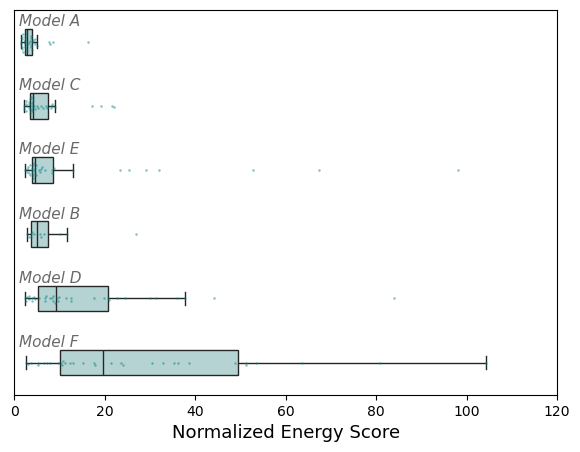

In [129]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
df = energyscoresdf_norm[energyscoresdf_norm.Label == 'Scenario F']
my_order = df.groupby(by=['Model'])['energyscore'].median().sort_values(ascending=True).index
    
bp =sns.boxplot(x='energyscore', y='Model', data=df, order=my_order, showfliers=False, color='teal', width=.4)

sns.swarmplot(x='energyscore', y='Model', data=df, order=my_order, color='teal',alpha = .5,size=1.75, orient="h")

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
    
plt.xlabel('Normalized Energy Score', fontsize=13)
plt.ylabel('')

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F'}


a = 0
for mod in list(my_order):
    plt.text(1,a-.25, modelmap[mod], fontsize=11, style='italic', color='dimgray')
    a+=1
    
bp.set(yticklabels=[])
bp.set(yticks=[])

plt.xlim([0,120])


plt.savefig('../figs/normalized_ES_scenF.pdf')

# make plots with baseline model

In [52]:
baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'

ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [53]:
ES_ratiodf

,Model,Label,location,energyscore,target,abbreviation,location_name,population,baseline_model,horizon,energyscore_baseline,ES_ratio
0,MOBS_NEU-GLEAM_FLU,Scenario A,10,63.366537,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.061673
1,MOBS_NEU-GLEAM_FLU,Scenario B,10,73.832873,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.237031
2,MOBS_NEU-GLEAM_FLU,Scenario C,10,51.835970,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,0.868484
3,MOBS_NEU-GLEAM_FLU,Scenario D,10,64.822412,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,1.086065
4,MOBS_NEU-GLEAM_FLU,Scenario E,10,52.877779,inc hosp,DE,Delaware,973764,flu-baseline,4,59.685549,0.885939
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,UT-ImmunoSEIRS,Scenario B,US,25598.171912,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,1.184685
1400,UT-ImmunoSEIRS,Scenario C,US,27081.777290,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,1.253346
1401,UT-ImmunoSEIRS,Scenario D,US,25498.213156,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,1.180059
1402,UT-ImmunoSEIRS,Scenario E,US,24345.522962,inc hosp,US,US,328728466,flu-baseline,4,21607.579224,1.126712


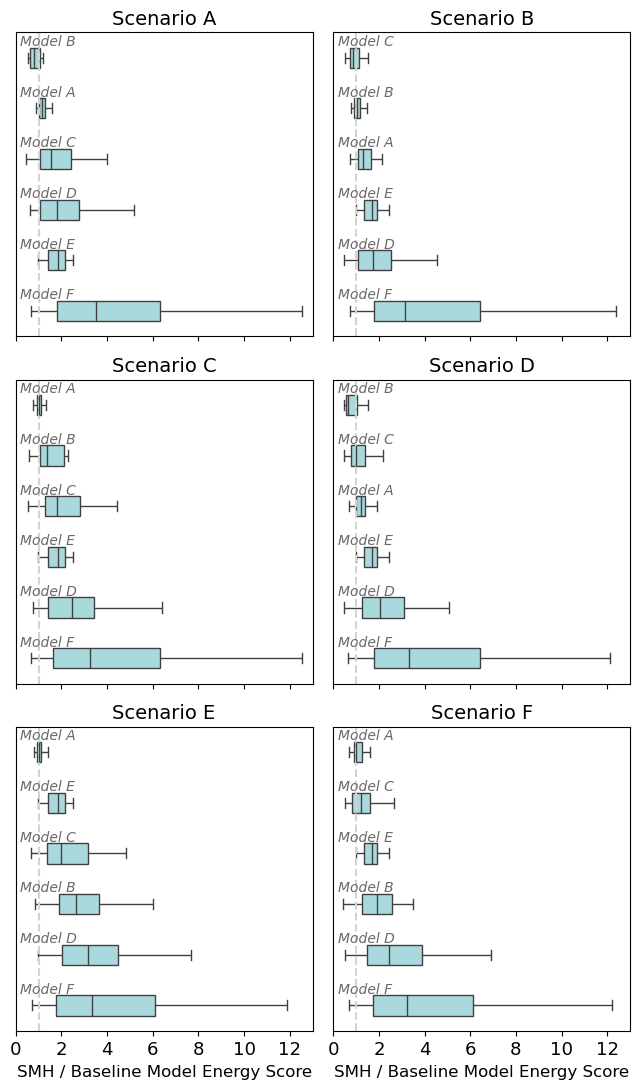

In [147]:
fig, ax = plt.subplots(3,2,figsize=(6.5,11), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in ES_ratiodf.Label.unique():
    plt.subplot(3,2,i)
    
    if i<3:
        x = 0
    elif i<5:
        x=1
    else:
        x=2
        
    if i in [1,3,5]:
        y=0
    else:
        y=1
    
    rankinfo = ES_ratiodf[ES_ratiodf.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["ES_ratio"].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='ES_ratio', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4,
                   showfliers=False)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('SMH / Baseline Model Energy Score', fontsize=12)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    plt.xlim([0, 13])
    
    
    for patch in ax[x][y].patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))

    # plot underlying distribution
   # sns.swarmplot(x='ES_ratio', y='Model', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .35,size=.9,
    #              orient="h")  
    
    plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

    
    a = 0
    for mod in list(my_order):
        plt.text(0.2,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('../figs/ESratio_flurd4.pdf')
plt.show()


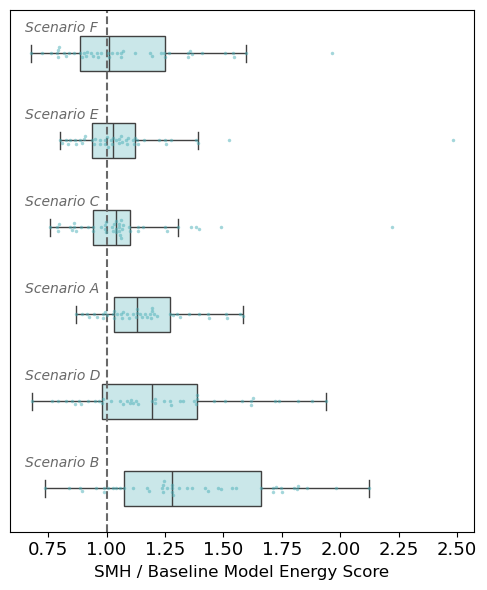

In [84]:
fig, ax = plt.subplots(1,1,figsize=(5,6), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
df = ES_ratiodf[ES_ratiodf.Model== 'MOBS_NEU-GLEAM_FLU']


my_order = df.groupby(by=["Label"])["ES_ratio"].median().sort_values(ascending=True).index

g = sns.boxplot(x='ES_ratio', y='Label', data=df, order = my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=df, order=my_order, color = "#49AFB7",alpha = .5,size=2.5,
              orient="h")  


g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('SMH / Baseline Model Energy Score', fontsize=12)


#plt.xlim([0, 13])

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .25))


plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'dimgray', alpha=1)


a = 0
for mod in list(my_order):
    plt.text(0.65,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()
#plt.savefig('../standardrank_WIS_717.pdf')
plt.show()


# look at rankings

In [189]:
# energy score rank

es_all = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")


# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [190]:
dfa =  pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl") 
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

dfa = dfa[~dfa['Model'].isin(singleloc_models)]


dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WIS')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)


dfrankallwis = dfrank.reset_index()
dfrankallwis = dfrankallwis.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_wis'})


In [191]:
dfrankall = dfrankallenergyscore.merge(dfrankallwis, on = ['Model', 'location', 'Label', 'target'])

In [293]:
dfrankall

,Model,location,standard_rank_ES,target,Label,standard_rank_wis
0,MOBS_NEU-GLEAM_FLU,1,1,hosp,Scenario A,1
1,NotreDame-FRED,1,2,hosp,Scenario A,2
2,UT-ImmunoSEIRS,1,3,hosp,Scenario A,3
3,USC-SIkJalpha,1,4,hosp,Scenario A,5
4,PSI-M2,1,5,hosp,Scenario A,4
...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,US,2,hosp,Scenario F,3
1628,NotreDame-FRED,US,3,hosp,Scenario F,4
1629,USC-SIkJalpha,US,4,hosp,Scenario F,5
1630,PSI-M2,US,5,hosp,Scenario F,2


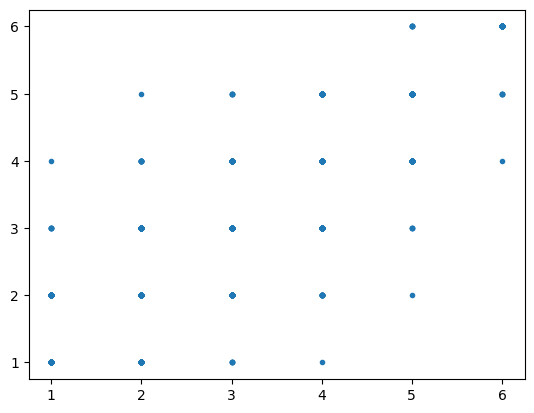

In [193]:
plt.plot(dfrankall.standard_rank_wis, dfrankall.standard_rank_ES,'.')

In [281]:
ranks = pd.DataFrame()
for model in dfrankall.Model.unique():
    for scenario in dfrankall.Label.unique():

        df = dfrankall[(dfrankall.Model==model) & (dfrankall.Label==scenario)]
        tau, pval = stats.kendalltau(df.standard_rank_wis, df.standard_rank_ES)
        
        row = pd.DataFrame({'Model':model, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranks = pd.concat([ranks, row])

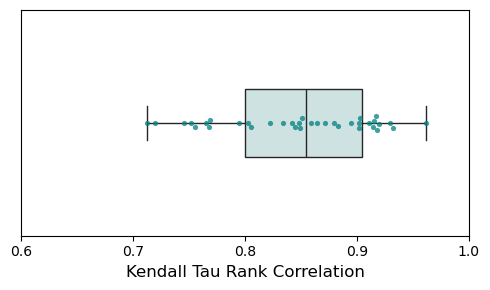

In [294]:
fig, ax = plt.subplots(figsize=(5,3))

g = sns.boxplot(x='tau', data=ranks, width=.3, showfliers=False,color='teal')

sns.swarmplot(x='tau', data=ranks,  color='teal', size=3.75, alpha=.75)
              
for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .2))

plt.xlim([.6,1.])
plt.yticks([])
plt.xticks([.6, .7, .8, .9, 1])

plt.xlabel('Kendall Tau Rank Correlation', fontsize=12)
plt.tight_layout()
plt.savefig('../figs/kendalltau_boxplot_rank.pdf')
plt.show()

In [296]:
ranks.median()

tau    0.854836
dtype: float64

(array([   2.,   21.,    0.,  164.,    0., 1259.,  162.,    0.,   22.,
           2.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

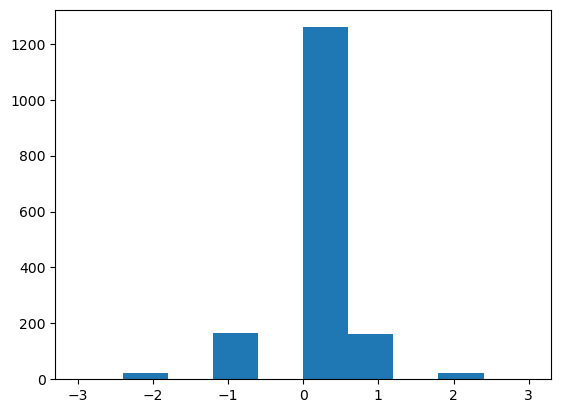

In [219]:
plt.hist(dfrankall.standard_rank_wis-dfrankall.standard_rank_ES)

In [245]:
es = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

wis =  pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_indiv_rd4_hosp_521.pkl") 
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

wis = wis[~wis['Model'].isin(singleloc_models)]

scores = es.merge(wis, on=['Model', 'location', 'Label', 'abbreviation', 'location_name', 'population','target'])

In [246]:
scores

,Model,Label,location,energyscore,target,abbreviation,location_name,population,WIS
0,MOBS_NEU-GLEAM_FLU,Scenario A,1,426.430823,hosp,AL,Alabama,4903185,45.891879
1,MOBS_NEU-GLEAM_FLU,Scenario B,1,410.700957,hosp,AL,Alabama,4903185,37.968114
2,MOBS_NEU-GLEAM_FLU,Scenario C,1,410.799822,hosp,AL,Alabama,4903185,44.269688
3,MOBS_NEU-GLEAM_FLU,Scenario D,1,408.848089,hosp,AL,Alabama,4903185,36.551048
4,MOBS_NEU-GLEAM_FLU,Scenario E,1,421.623785,hosp,AL,Alabama,4903185,46.840356
...,...,...,...,...,...,...,...,...,...
1627,UT-ImmunoSEIRS,Scenario B,US,25598.171912,hosp,US,US,328728466,2728.481059
1628,UT-ImmunoSEIRS,Scenario C,US,27081.777290,hosp,US,US,328728466,2913.826165
1629,UT-ImmunoSEIRS,Scenario D,US,25498.213156,hosp,US,US,328728466,2734.306769
1630,UT-ImmunoSEIRS,Scenario E,US,24345.522962,hosp,US,US,328728466,2572.279479


In [248]:
stats.spearmanr(scores.energyscore, scores.WIS)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.9937821002365366, pvalue=0.0)

In [257]:
ranks = pd.DataFrame()
for model in scores.Model.unique():
    for scenario in scores.Label.unique():

        df = scores[(scores.Model==model) & (scores.Label==scenario)]
        tau, pval = stats.kendalltau(df.WIS, df.energyscore)
        
        row = pd.DataFrame({'Model':model, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranks = pd.concat([ranks, row])

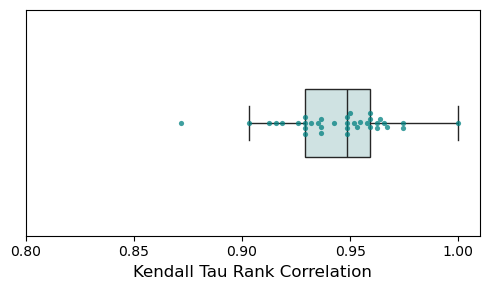

In [280]:
fig, ax = plt.subplots(figsize=(5,3))
g = sns.boxplot(x='tau', data=ranks, width=.3, showfliers=False,color='teal')

sns.swarmplot(x='tau', data=ranks, color='teal', size=3.75, alpha=.75)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .2))

plt.xlim([.8,1.01])
plt.yticks([])
plt.xticks([.8, .85, .9, .95, 1])

plt.xlabel('Kendall Tau Rank Correlation', fontsize=12)
plt.tight_layout()
plt.savefig('../figs/kendalltau_boxplot.pdf')
plt.show()